# Classification Task Results

In [1]:
from sklearn.metrics import precision_recall_fscore_support
from difflib import SequenceMatcher
from scripts.config import DefaultArgsNamespace
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import average_precision_score, precision_recall_curve

from metrics.metrics import *

In [2]:
args = DefaultArgsNamespace()

results_csv = './results/model_id_65620060_on_20241101-203821/preds.csv'
# path to results csv
results_dir = results_csv.rsplit('/', 1)[0]

task = args.dataloader_params['task']
print("Task is", task)

Task is segmentation


# Preprocessing

In [3]:
# get keysteps dict
keysteps_dict = args.dataloader_params['keysteps']
# Inverting the dictionary to map keystep_id to natural language description
keystep_id_to_desc = {i: v for i, v in enumerate(keysteps_dict.values())}

keysteps_dict = keystep_id_to_desc


In [4]:
df = pd.read_csv(results_csv)

keysteps_dict = args.dataloader_params['keysteps']
print(keysteps_dict)

# Inverting the dictionary to map keystep_id to natural language description
keystep_id_to_desc = {i: v for i, v in enumerate(keysteps_dict.values())}

# Adding a new column to the dataframe that maps keystep_id to the corresponding natural language description
df['keystep_description'] = df['keystep_id'].map(keystep_id_to_desc)
df['pred_keystep_description'] = df['pred_keystep_id'].map(keystep_id_to_desc)

# Display the updated dataframe
df.head()

{'approach_patient': 'Approach the patient', 'check_responsiveness': 'Check for responsiveness', 'check_pulse': "Check patient's pulse", 'check_breathing': 'Check if patient is breathing', 'chest_compressions': 'Perform chest compressions', 'request_aed': 'Request an AED', 'request_assistance': 'Request additional assistance', 'turn_on_aed': 'Turn on the AED', 'attach_defib_pads': 'Attach defibrillator pads', 'clear_for_analysis': 'Clear for analysis', 'clear_for_shock': 'Clear for shock', 'administer_shock_aed': 'Administer shock using AED', 'open_airway': "Open patient's airway", 'place_bvm': 'Place bag valve mask (BVM)', 'ventilate_patient': 'Ventilate patient', 'no_action': 'No action', 'assess_patient': 'Assess the patient', 'explain_procedure': 'Explain the ECG procedure to the patient', 'shave_patient': 'Shave/Cleanse the patient for ECG', 'place_left_arm_lead': 'Place the lead on left arm for ECG', 'place_right_arm_lead': 'Place the lead on right arm for ECG', 'place_left_leg_l

,keystep_label,keystep_id,start_frame,end_frame,start_t,end_t,window_start_frame,window_end_frame,subject_id,trial_id,pred_keystep_id,all_preds,keystep_description,pred_keystep_description
0,approach_patient,0,0,74,0.00000,2.49139,-1,-1,ms1,5,0,"[[8.439959526062012, 1.4502333402633667, 0.521...",Approach the patient,Approach the patient
1,check_responsiveness,1,74,140,2.49100,4.67727,-1,-1,ms1,5,1,"[[5.325057029724121, 7.048859119415283, 2.9126...",Check for responsiveness,Check for responsiveness
2,check_pulse,2,140,262,4.67700,8.77286,-1,-1,ms1,5,2,"[[0.7133340239524841, 4.864084243774414, 7.500...",Check patient's pulse,Check patient's pulse
3,check_breathing,3,171,275,5.71403,9.19197,-1,-1,ms1,5,2,"[[0.8958125710487366, 4.464751720428467, 7.564...",Check if patient is breathing,Check patient's pulse
4,request_assistance,6,314,362,10.48142,12.10000,-1,-1,ms1,5,5,"[[0.6017309427261353, 5.063621520996094, 0.478...",Request additional assistance,Request an AED


# Generate metrics

In [5]:
# Grouping by subject_id and trial_id
results = []

# Assuming 'results_csv' is defined earlier and points to the path of the results CSV
results_dir = results_csv.rsplit('/', 1)[0]


all_accuracy = []
all_edit_distances = []
all_edit_scores = []
all_precisions = []
all_recalls = []
all_f1_k = []

all_ground_truth = []
all_predicted = []

for (subject, trial), group in df.groupby(['subject_id', 'trial_id']):
    print("*" * 50)
    print(f"Subject: {subject}, Trial: {trial}")
    
    # Extract ground truth and predicted keysteps
    ground_truth = group['keystep_id'].tolist()  # Ground truth per frame
    predicted = group['pred_keystep_id'].tolist()  # Predicted per frame
    

    # Calculate edit distance
    edit_distance = calculate_edit_distance(ground_truth, predicted)
    # Calculate edit score
    edit_score = calculate_edit_score(ground_truth, predicted, edit_distance)


    all_edit_distances.append(edit_distance)
    all_edit_scores.append(edit_score)

    print("edit_distance: ", edit_distance)
    print("edit_score: ", edit_score)

    all_ground_truth.append(ground_truth)
    all_predicted.append(predicted)

    f1_aggregated_metrics = {}

    f1_score, precision, recall = calculate_f1_classification(ground_truth, predicted)
    # Store precision, recall, f1 metrics for each threshold
    metrics = {
        f'precision': precision,
        f'recall': recall,
        f'f1': f1_score,
    }
    # Append precision, recall, and f1 to the respective lists
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1_k.append(f1_score)


    ## Calculate accuracy
    accuracy = np.mean(np.array(ground_truth) == np.array(predicted))
    print("accuracy: ", accuracy)
    
    all_accuracy.append(accuracy)

    # Append ground truth and predicted to global lists
    all_ground_truth.append(ground_truth)
    all_predicted.append(predicted)

    # Append result for this subject and trial
    results.append({
        'subject_id': subject,
        'trial_id': trial,
        'accuracy': accuracy,
        'edit_distance': edit_distance,
        'edit_score': edit_score,
        'f1': f1_score,
        'precision': precision,
        'recall': recall,
        'ground_truth': ground_truth,
        'predicted': predicted,
    })



**************************************************
Subject: ms1, Trial: 0
edit_distance:  5
edit_score:  0.5455
accuracy:  0.5454545454545454
**************************************************
Subject: ms1, Trial: 1
edit_distance:  10
edit_score:  0.4444
accuracy:  0.4444444444444444
**************************************************
Subject: ms1, Trial: 5
edit_distance:  6
edit_score:  0.6842
accuracy:  0.6842105263157895
**************************************************
Subject: ms2, Trial: 4
edit_distance:  7
edit_score:  0.6316
accuracy:  0.631578947368421
**************************************************
Subject: ng1, Trial: 0
edit_distance:  7
edit_score:  0.3636
accuracy:  0.36363636363636365
**************************************************
Subject: ng2, Trial: 0
edit_distance:  9
edit_score:  0.6087
accuracy:  0.6086956521739131
**************************************************
Subject: ng3, Trial: 1
edit_distance:  6
edit_score:  0.7
accuracy:  0.7
***********************

/scratch/cjh9fw/conda/egoexoems/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch/cjh9fw/conda/egoexoems/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch/cjh9fw/conda/egoexoems/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch/cjh9fw/conda/egoexoems/lib/python3.8/site-

### Save results to csvs

In [6]:
# Save the results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv(f'{results_dir}/subject_wise_results.csv', index=False)

# Calculate average metrics
average_accuracy = np.mean(all_accuracy)
average_edit_distance = int(np.mean(all_edit_distances))
average_edit_score = np.mean(all_edit_scores)

# Calculate the average precision, recall, and f1 for each IoU threshold
average_precisions = {f'average_precision': np.mean(all_precisions)}
average_recalls = {f'average_recall': np.mean(all_recalls)}
average_f1_k = {f'average_f1': np.mean(all_f1_k)}

# Prepare the dictionary for average metrics
average_metrics = {
    'accuracy': average_accuracy,
    'edit_distance': average_edit_distance,
    'edit_score': average_edit_score,
}
average_metrics.update(average_precisions)
average_metrics.update(average_recalls)
average_metrics.update(average_f1_k)

# Convert the average metrics dictionary to a DataFrame and save it as CSV
# Define the desired order of columns
column_order = ['average_precision', 'average_recall', 'average_f1', 'accuracy', 'edit_score', 'edit_distance']
# Convert the average metrics dictionary to a DataFrame and reorder columns
average_metrics_df = pd.DataFrame(average_metrics, index=[0])[column_order]

average_metrics_df.to_csv(f'{results_dir}/average_metrics.csv', index=False)

all_ground_truth = np.concatenate(all_ground_truth)
all_predicted = np.concatenate(all_predicted)
unique_actions = np.unique(np.union1d(all_predicted, all_ground_truth))
print("Unique actions: ", unique_actions)

# Calculate final class-wise accuracy across all trials
final_classwise_accuracy = calculate_final_classwise_accuracy(all_ground_truth, all_predicted, unique_actions)
print("Final Class-wise Accuracy:")
for action, accuracy in final_classwise_accuracy.items():
    print(f"{action}: {accuracy}")

# Save the final class-wise accuracy to CSV
classwise_accuracy_df = pd.DataFrame.from_dict(final_classwise_accuracy, orient='index', columns=['accuracy'])
classwise_accuracy_csv_path = f'{results_dir}/final_classwise_accuracy.csv'
classwise_accuracy_df.to_csv(classwise_accuracy_csv_path, index_label='action')


Unique actions:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24
 25 26 27 28 29 30 33 34]


Final Class-wise Accuracy:
0: 0.75
1: 0.65
2: 0.5938
3: 0.4286
4: 0.8684
5: 0.3333
6: 0.2222
7: 0.3684
8: 0.75
9: 0.7727
10: 0.5
11: 0.5238
12: 0.5
13: 0.7627
14: 0.8194
15: 0.3684
16: 0.6667
17: 0.1667
19: 0.0
20: 0.3333
21: 0.0
22: 0.2
23: 0.0
24: 0.0
25: 0.0
26: 0.4
27: 0.2
28: 0.4
29: 0.0
30: 0.2
33: 0.8
34: 0.0


# Plotting

### Helper functions

In [7]:
import matplotlib.cm as cm


# Function to generate a color map for keystep IDs with distinct colors, excluding red shades
def get_unique_colors(num_colors):
    # Use a base colormap (e.g., hsv)
    cmap = cm.get_cmap('tab20')  # Get 'num_colors' evenly spaced colors from the colormap
    
    # Generate the list of colors by sampling the colormap
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    return colors

# get keysteps dict
keysteps_dict = args.dataloader_params['keysteps']
# Inverting the dictionary to map keystep_id to natural language description
keystep_id_to_desc = {i: v for i, v in enumerate(keysteps_dict.values())}

keysteps_dict = keystep_id_to_desc

# Get unique colors for the number of keysteps
num_keysteps = len(keysteps_dict)
colors = get_unique_colors(num_keysteps)

# Create a color dictionary mapping keystep IDs to colors
keystep_color_dict = {keystep_id: colors[i] for i, keystep_id in enumerate(keysteps_dict.keys())}

# Output the dictionary for reference
keystep_color_dict


/tmp/ipykernel_516633/906976968.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')  # Get 'num_colors' evenly spaced colors from the colormap


{0: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 1: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 2: (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 3: (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 4: (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 5: (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 6: (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
 7: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 8: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 9: (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0),
 10: (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0),
 11: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 12: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 13: (1.0, 0.596078431372549, 0.5882352941176471, 1.0),
 14: (0.5803921568627451, 0.403921568627451, 0.74117

# Plot Keysteps

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import matplotlib.cm as cm

# Function to generate a color map for keystep IDs with distinct colors
def get_unique_colors(num_colors):
    return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors

# Function to plot keystep sequences with unique colors and a legend at the bottom
def plot_keystep_sequences(ground_truth, predicted, subject, trial, keystep_dict, plots_dir):
    print("Plotting keystep sequences")
    print(ground_truth)
    print(predicted)
    # Get unique keystep IDs for ground truth and predicted keysteps
    all_keysteps = list(set(ground_truth['keystep_id'].unique()).union(set(predicted['pred_keystep_id'].unique())))
    print((all_keysteps))
    # Generate a color map with as many unique colors as there are keysteps
    color_map = get_unique_colors(len(all_keysteps))
    color_dict = {keystep_id: color_map(i) for i, keystep_id in enumerate(all_keysteps)}
    print("color duict", color_dict)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 5))  # Increased height and width for better spacing

    # Plot ground truth keysteps
    y_pos_gt = 0  # Position for ground truth timeline
    for i, (start, end, keystep_id) in enumerate(zip(ground_truth['start_frame'], ground_truth['end_frame'], ground_truth['keystep_id'])):
        width = max(end - start, 5)  # Ensure a minimum width for short keysteps
        rect = patches.Rectangle((start, y_pos_gt), width, 1, edgecolor=color_dict[keystep_id], facecolor=color_dict[keystep_id], linewidth=2, alpha=0.85)
        ax.add_patch(rect)

    # Plot predicted keysteps with mismatch highlighting
    y_pos_pred = 2  # Increased vertical space between ground truth and prediction
    for i, (start, end, pred_keystep_id) in enumerate(zip(predicted['start_frame'], predicted['end_frame'], predicted['pred_keystep_id'])):
        width = max(end - start, 5)  # Ensure a minimum width for short keysteps
        gt_keystep_id = ground_truth['keystep_id'].iloc[i] if i < len(ground_truth) else None
        if pred_keystep_id != gt_keystep_id:
            # Mismatch: use thicker red boundary
            rect = patches.Rectangle((start, y_pos_pred), width, 1, edgecolor='black', facecolor=color_dict[pred_keystep_id], linewidth=3, alpha=0.85)
            # print("Mismatch")
            # print(f"Predicted: {pred_keystep_id}, Ground Truth: {gt_keystep_id}, Start: {start}, End: {end}")
        else:
            # Match: use normal boundary color
            rect = patches.Rectangle((start, y_pos_pred), width, 1, edgecolor=color_dict[pred_keystep_id], facecolor=color_dict[pred_keystep_id], linewidth=2, alpha=0.85)
        ax.add_patch(rect)

    # Add labels for the timelines
    ax.text(-300, y_pos_gt + 0.5, 'Ground Truth', va='center', fontsize=10, color='blue')
    ax.text(-300, y_pos_pred + 0.5, 'Prediction', va='center', fontsize=10, color='red')

    # Create a horizontal legend at the bottom
    legend_elements = [patches.Patch(facecolor=color_dict[k], edgecolor=color_dict[k], label=f"{k}: {keystep_dict[k]}") for k in all_keysteps]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=4, title="Keysteps")

    # Set axis limits and labels
    ax.set_xlim([0, max(ground_truth['end_frame'].max(), predicted['end_frame'].max())])
    ax.set_ylim([-1, 4])
    ax.set_xlabel('Frame Number')
    ax.set_title(f'Keystep Sequences for Subject {subject} Trial {trial}')

    # Hide y-axis
    ax.get_yaxis().set_visible(False)

    # hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # save figure
    plt.savefig(f'{plots_dir}/subject_{subject}_trial_{trial}_keystep_sequence.png', bbox_inches='tight')
    # # Show plot
    # plt.tight_layout()
    # plt.show()




### Bar plot Horizontal

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Function to generate a color map for keystep IDs with distinct colors
def get_unique_colors(num_colors):
    return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors

# Function to plot keystep sequences using horizontal bar plot
def plot_keystep_bars(ground_truth, predicted, subject, trial, keystep_dict, plots_dir):
    # Get unique keystep IDs for ground truth and predicted keysteps
    all_keysteps = list(set(ground_truth['keystep_id'].unique()).union(set(predicted['pred_keystep_id'].unique())))

    # Generate a color map with as many unique colors as there are keysteps
    color_map = get_unique_colors(len(all_keysteps))
    color_dict = {keystep_id: color_map(i) for i, keystep_id in enumerate(all_keysteps)}

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 7))  # Increased height for better spacing

    # Plot horizontal bars for ground truth keysteps
    y_pos_gt = 0  # Position for ground truth timeline
    for i, (start, end, keystep_id) in enumerate(zip(ground_truth['start_frame'], ground_truth['end_frame'], ground_truth['keystep_id'])):
        width = max(end - start, 5)  # Ensure a minimum width of 5 for visibility
        ax.barh(y_pos_gt, width, left=start, height=0.6, color=color_dict[keystep_id], edgecolor='black',  linewidth=0.25)
        y_pos_gt += 1  # Move to next row for ground truth

    # Plot horizontal bars for predicted keysteps
    y_pos_pred = y_pos_gt + 1  # Leave a gap between ground truth and predicted
    for i, (start, end, pred_keystep_id) in enumerate(zip(predicted['start_frame'], predicted['end_frame'], predicted['pred_keystep_id'])):
        width = max(end - start, 5)  # Ensure a minimum width of 5 for visibility
        if pred_keystep_id != ground_truth['keystep_id'].iloc[i]:
            ax.barh(y_pos_pred, width, left=start, height=0.6, color=color_dict[pred_keystep_id], edgecolor='black', linewidth=2, hatch='//')  # Highlight mismatches
            # ax.barh(y_pos_pred, width, left=start, height=0.6, color=color_dict[pred_keystep_id], edgecolor='black', linewidth=2)  # Highlight mismatches

        else:
            ax.barh(y_pos_pred, width, left=start, height=0.6, color=color_dict[pred_keystep_id], edgecolor='black', linewidth=0.25)
        y_pos_pred += 1  # Move to next row for predicted

    # Create a horizontal legend at the bottom
    legend_elements = [plt.Line2D([0], [0], color=color_dict[k], lw=4, label=f"{k}: {keystep_dict[k]}") for k in all_keysteps]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=4, title="Keysteps")

    # Add labels for the timelines
    ax.text(-300, y_pos_gt - 7, 'Ground Truth', va='center', fontsize=10, color='blue')
    ax.text(-300, y_pos_pred - 6, 'Prediction', va='center', fontsize=10, color='red')

    # hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)


    # Set axis limits and labels
    ax.set_xlim([0, max(ground_truth['end_frame'].max(), predicted['end_frame'].max())])
    ax.set_yticks([])  # Hide y-axis labels
    ax.set_xlabel('Frame Number')
    ax.set_title(f'Keystep Sequences for Subject {subject} Trial {trial}')

    # save figure
    plt.savefig(f'{plots_dir}/subject_{subject}_trial_{trial}_keystep_bars.png', bbox_inches='tight')
    # Show plot
    # plt.tight_layout()
    # plt.show()


### Plot keysteps sequence in a single timeline

In [10]:

# plots_dir = f'{results_dir}/plots'
# os.makedirs(plots_dir, exist_ok=True)

# # Example usage with one subject's trial data
# for (subject, trial), group in df.groupby(['subject_id', 'trial_id']):
#     ground_truth_data = group[['keystep_id', 'start_frame', 'end_frame']]
#     predicted_data = group[['pred_keystep_id', 'start_frame', 'end_frame']]

#     plots_dir = f'{results_dir}/plots/sequence_plots'
#     os.makedirs(plots_dir, exist_ok=True)
#     # save figure
#     # Plot using the keystep IDs with unique colors, thicker boundaries, and a horizontal legend
#     plot_keystep_sequences(ground_truth_data, predicted_data, subject, trial, keysteps_dict, plots_dir)
#     break  # Only plot the first subject's trial for now

### Plot bar stacked timeline

{'approach_patient': 'Approach the patient', 'check_responsiveness': 'Check for responsiveness', 'check_pulse': "Check patient's pulse", 'check_breathing': 'Check if patient is breathing', 'chest_compressions': 'Perform chest compressions', 'request_aed': 'Request an AED', 'request_assistance': 'Request additional assistance', 'turn_on_aed': 'Turn on the AED', 'attach_defib_pads': 'Attach defibrillator pads', 'clear_for_analysis': 'Clear for analysis', 'clear_for_shock': 'Clear for shock', 'administer_shock_aed': 'Administer shock using AED', 'open_airway': "Open patient's airway", 'place_bvm': 'Place bag valve mask (BVM)', 'ventilate_patient': 'Ventilate patient', 'no_action': 'No action', 'assess_patient': 'Assess the patient', 'explain_procedure': 'Explain the ECG procedure to the patient', 'shave_patient': 'Shave/Cleanse the patient for ECG', 'place_left_arm_lead': 'Place the lead on left arm for ECG', 'place_right_arm_lead': 'Place the lead on right arm for ECG', 'place_left_leg_l

/tmp/ipykernel_516633/3677983048.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors
/tmp/ipykernel_516633/3677983048.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors
/tmp/ipykernel_516633/3677983048.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors
/

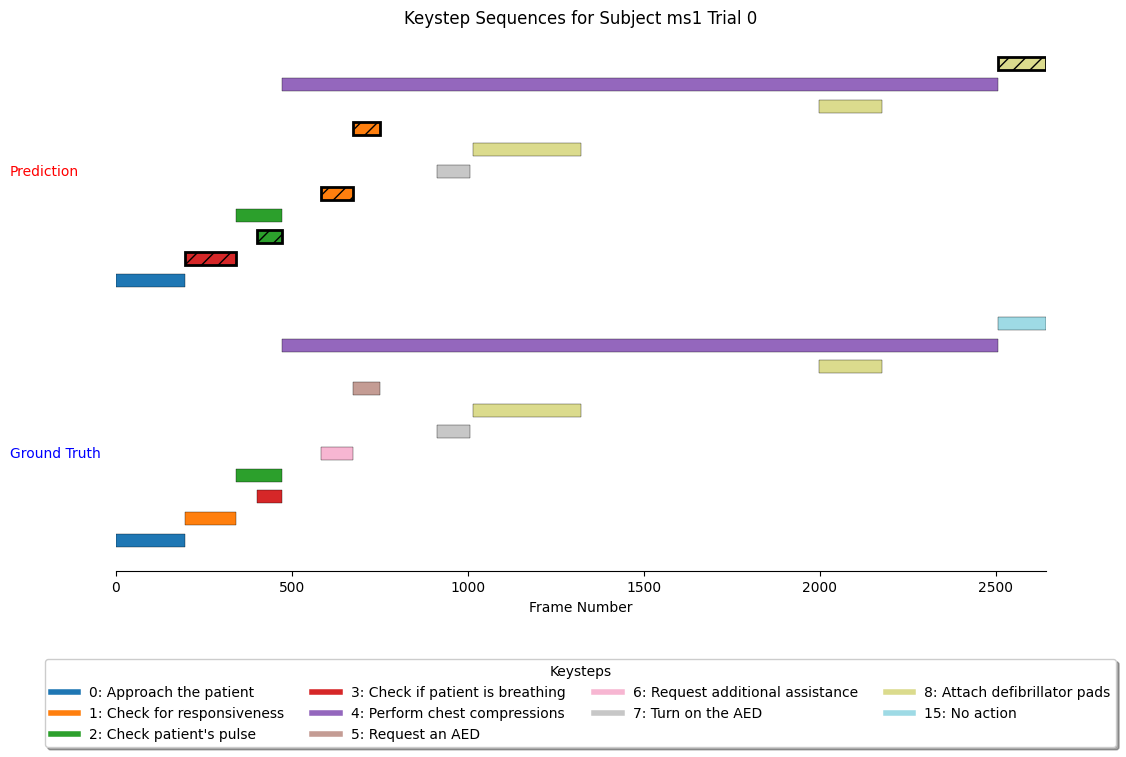

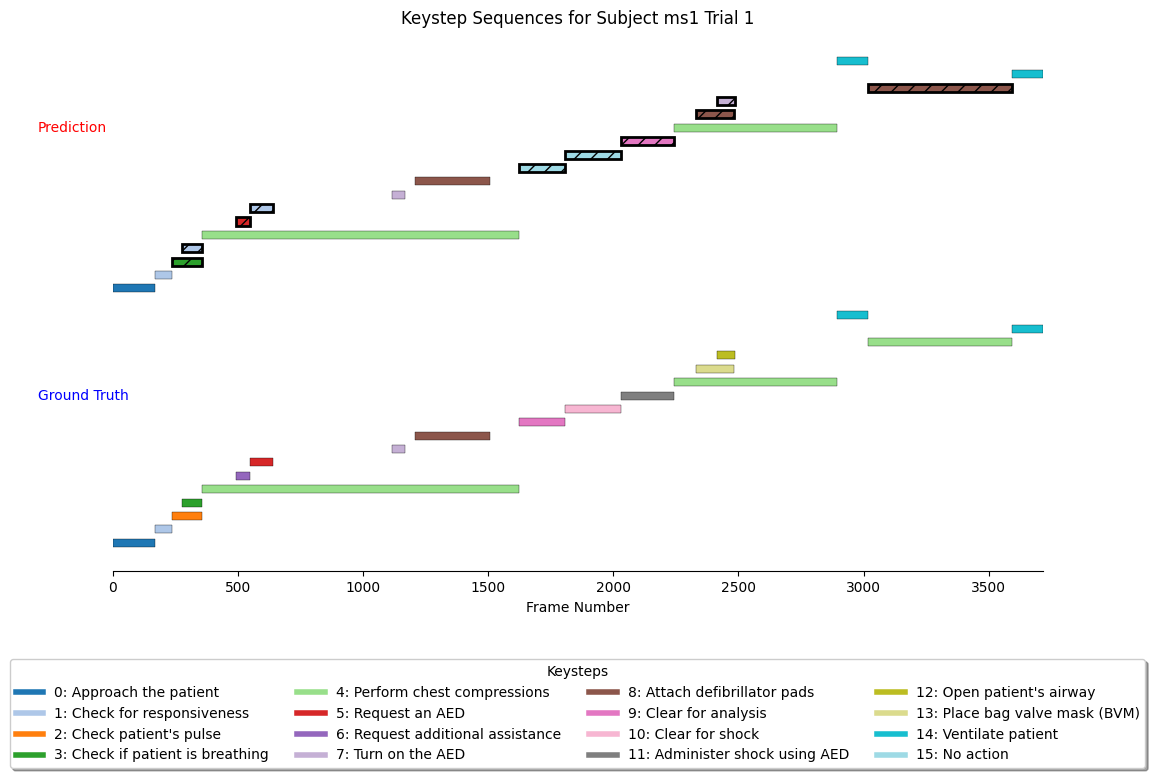

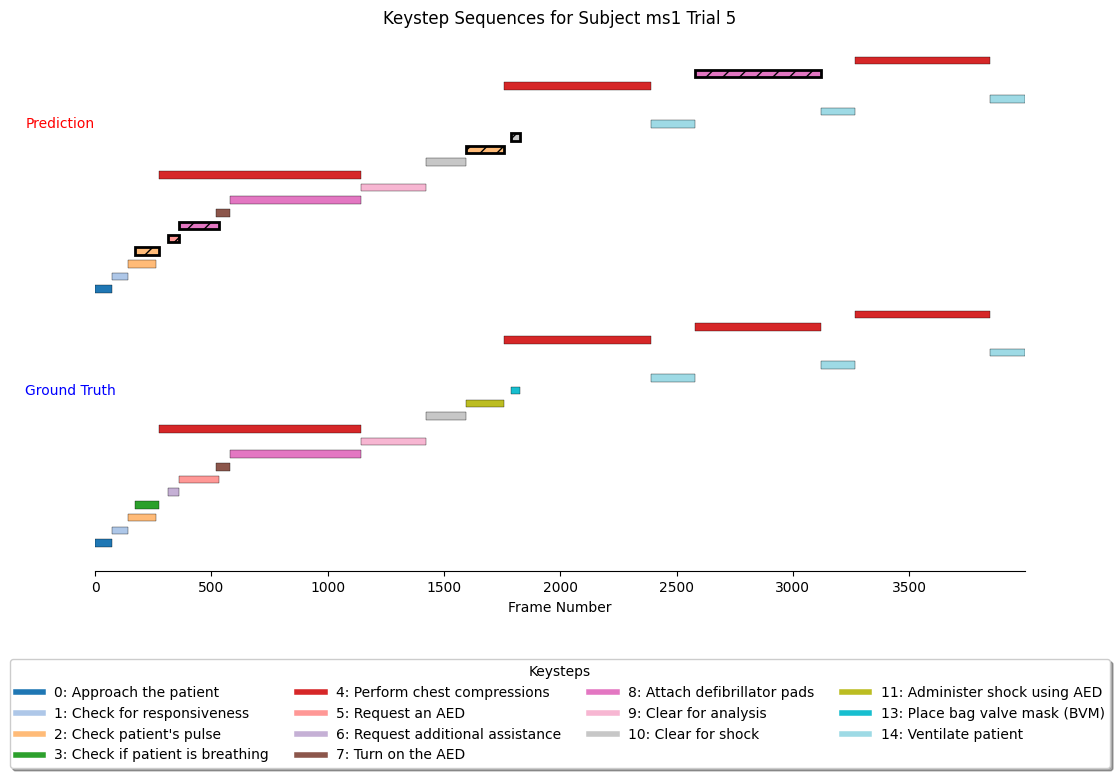

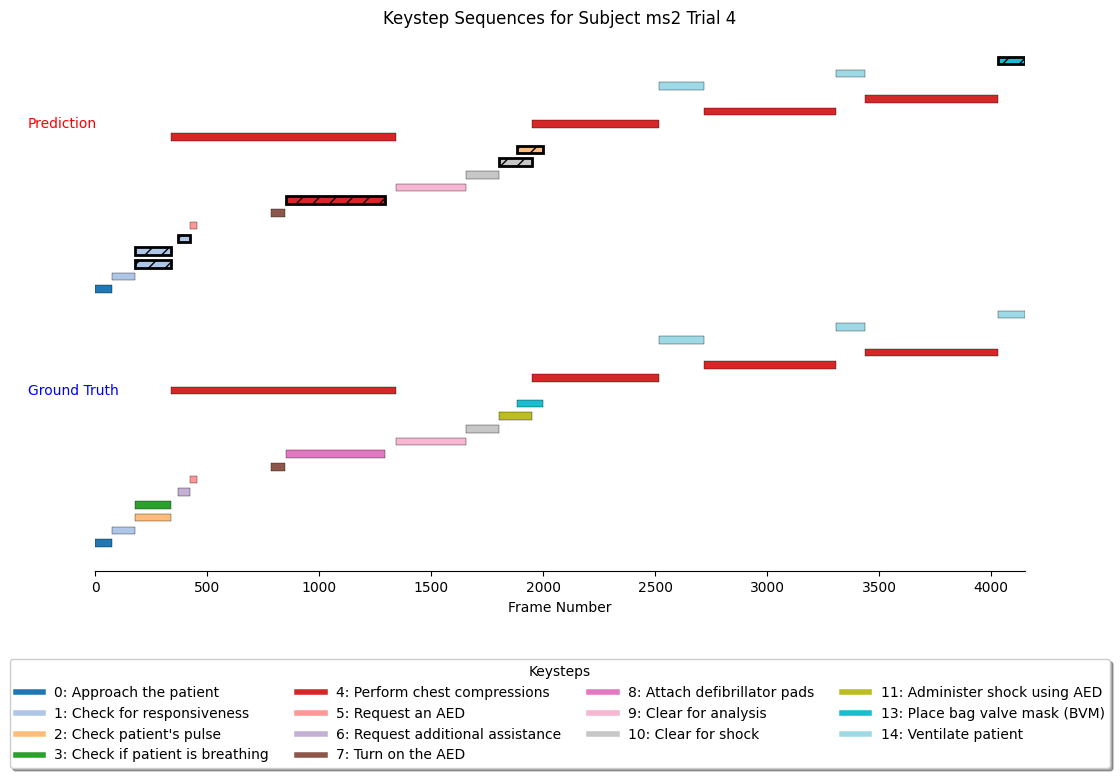

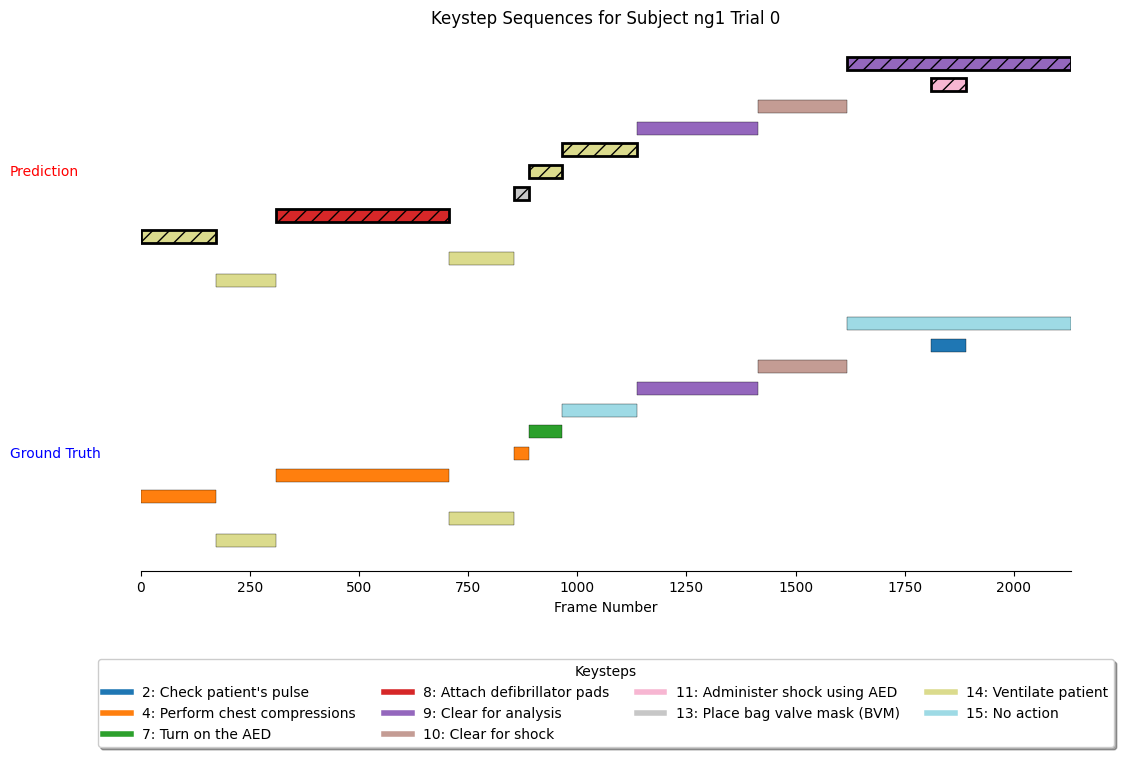

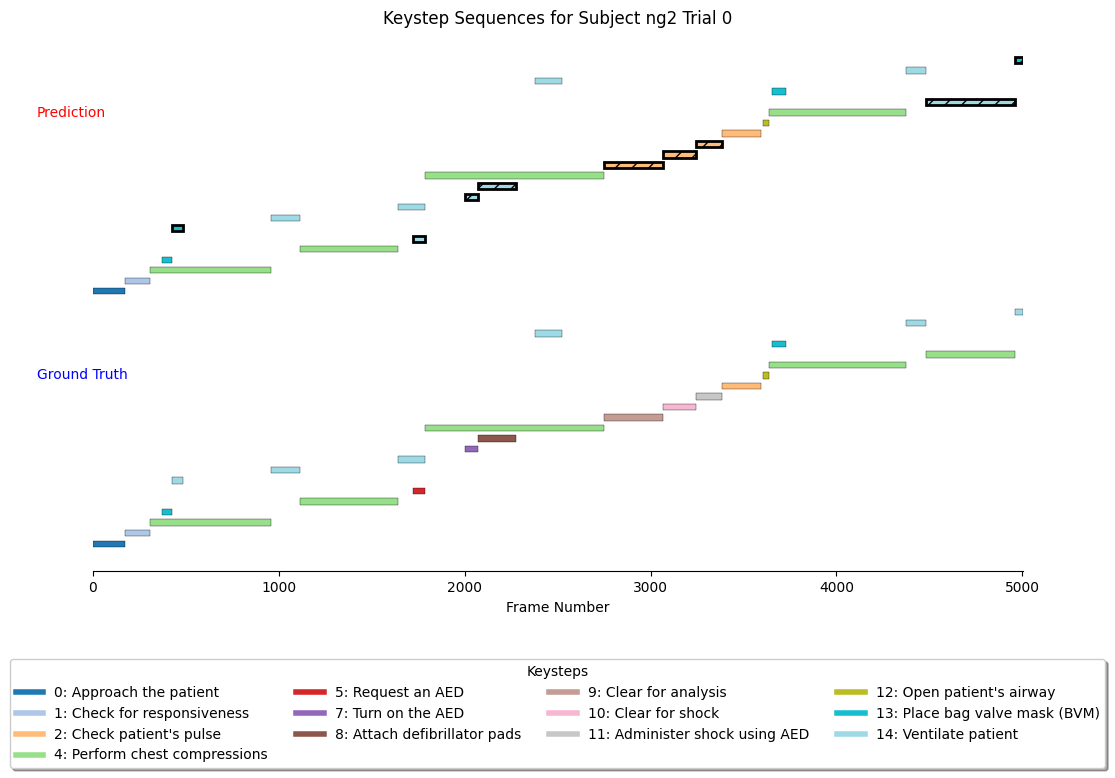

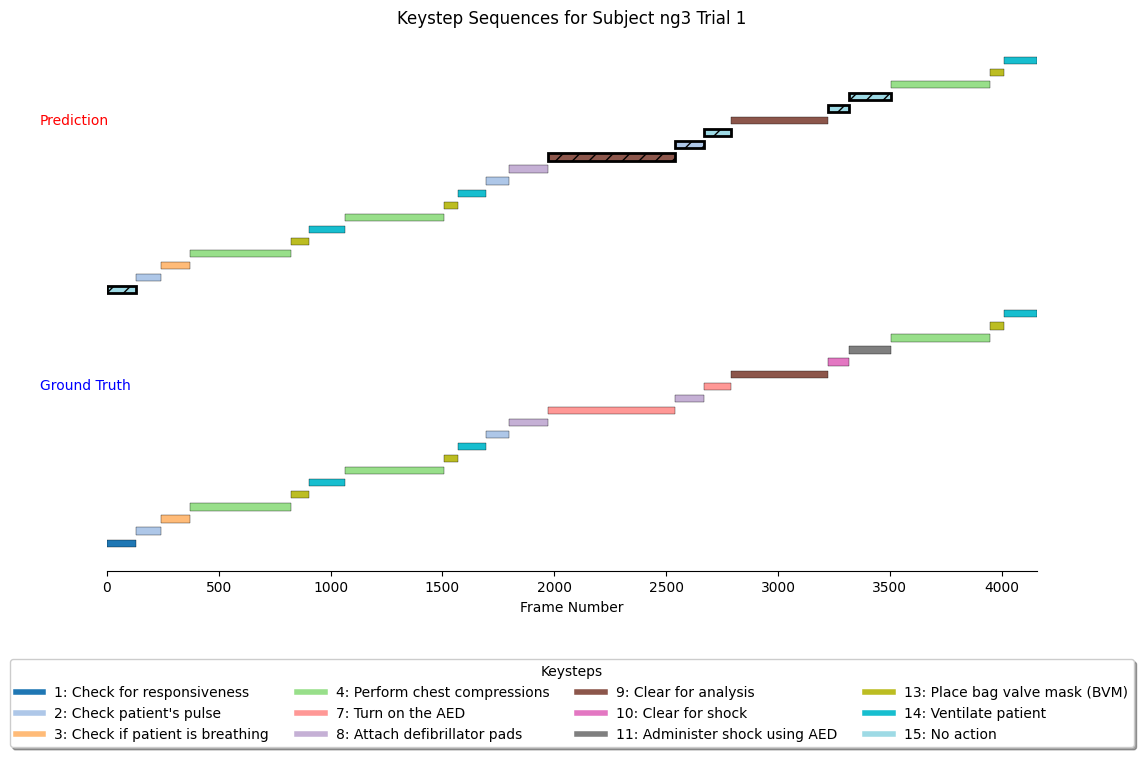

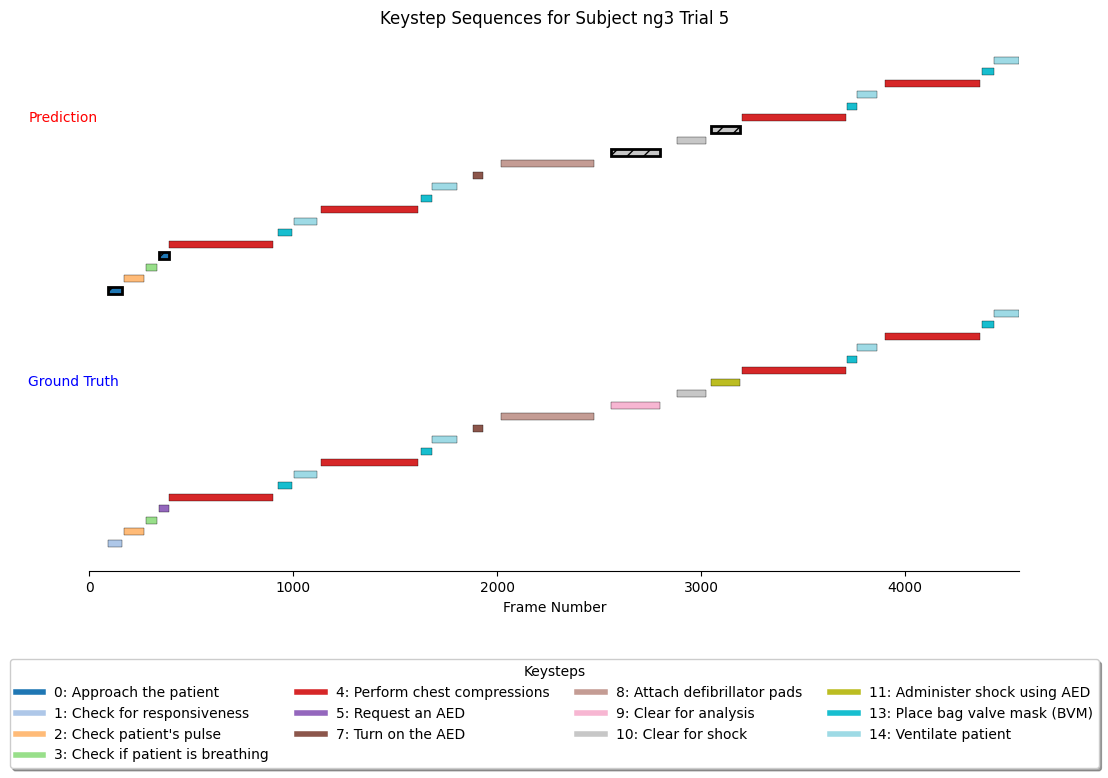

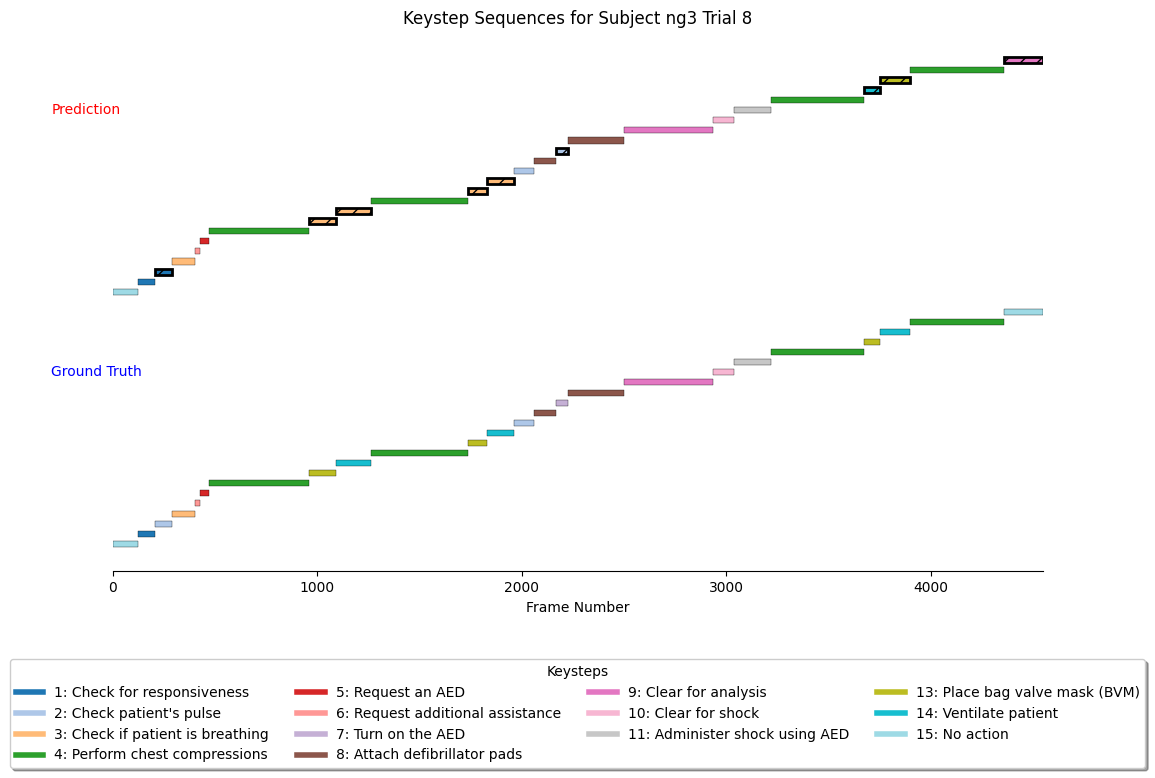

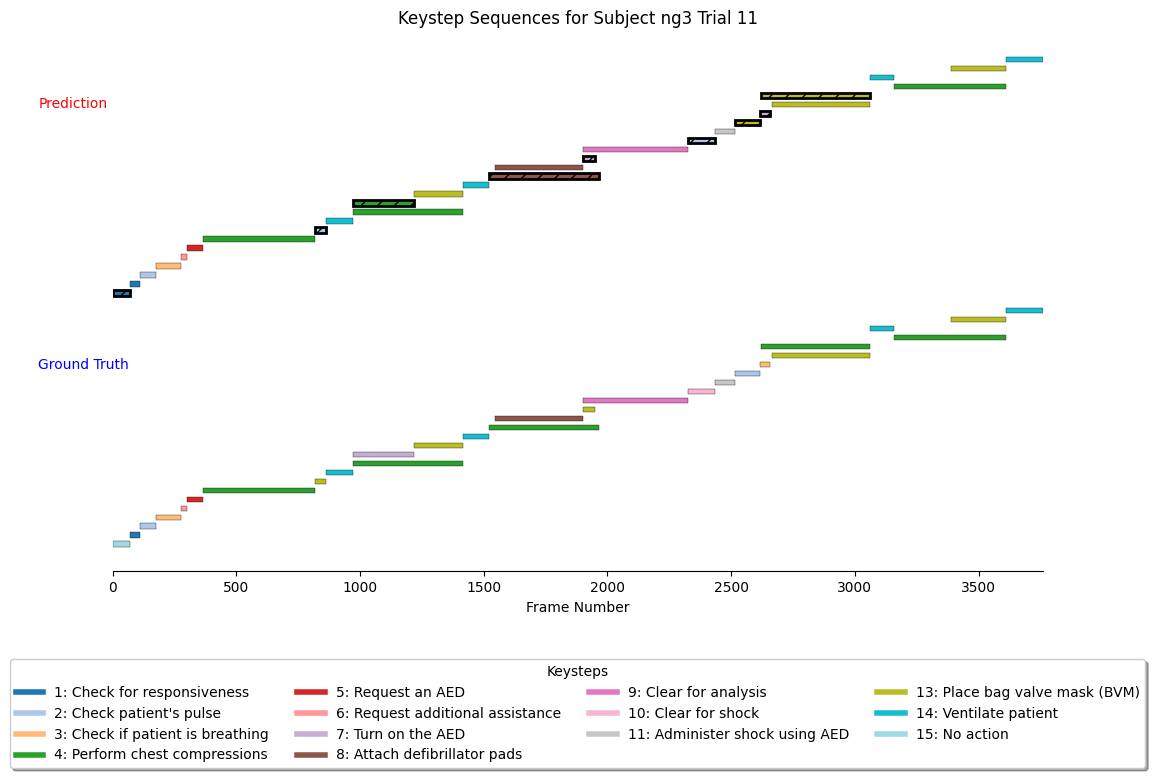

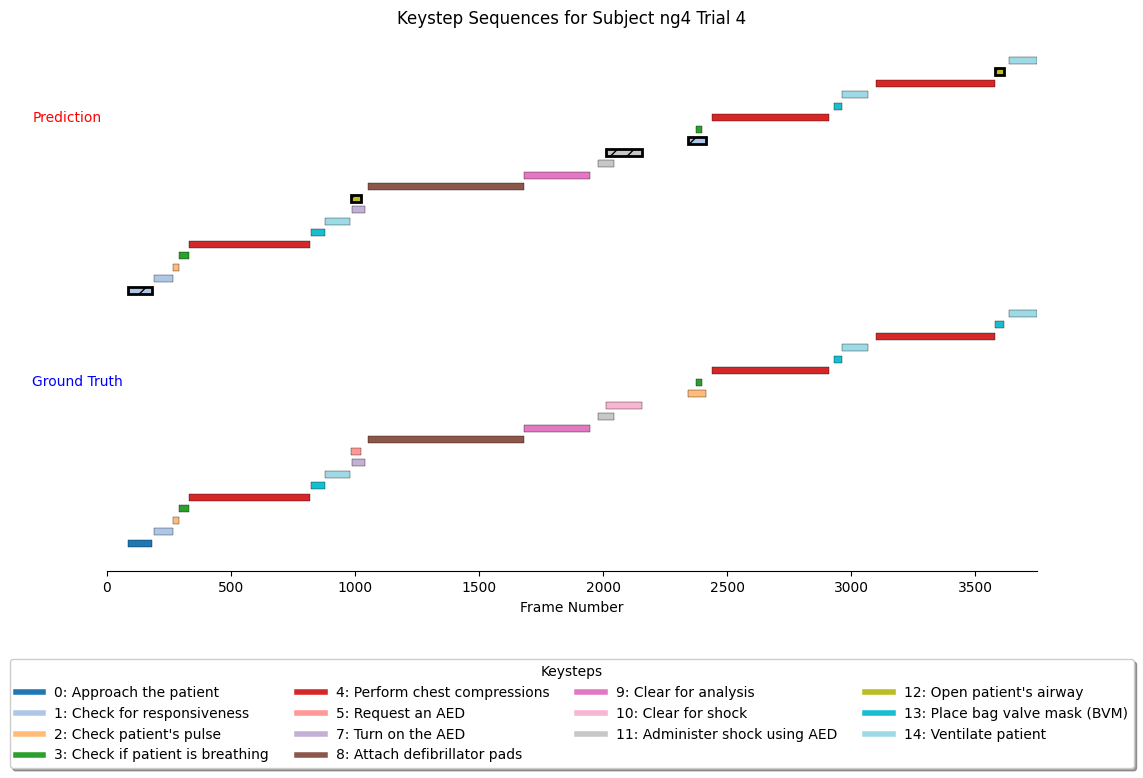

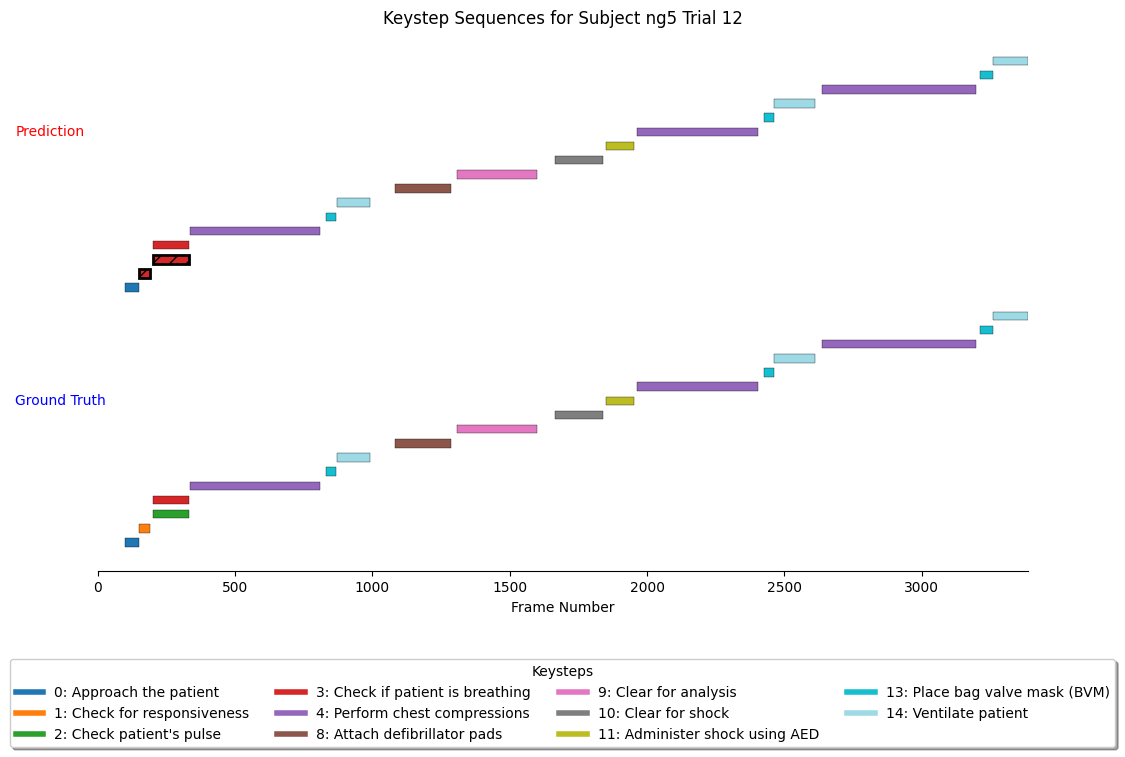

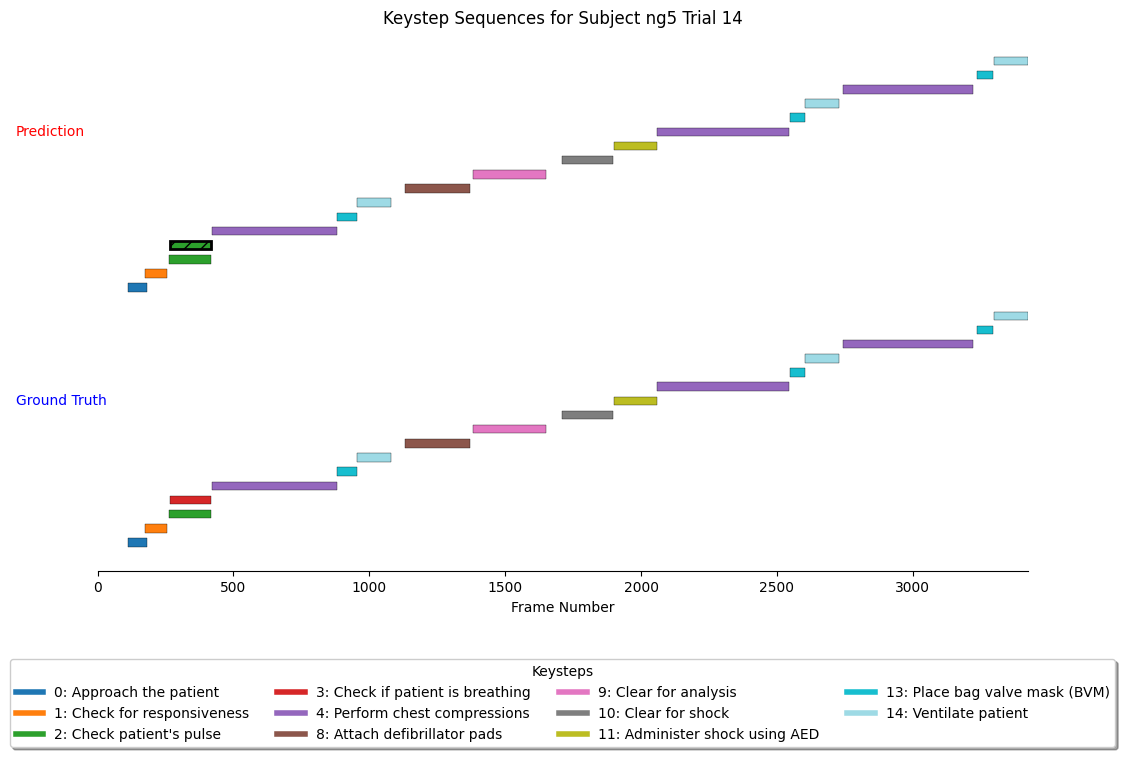

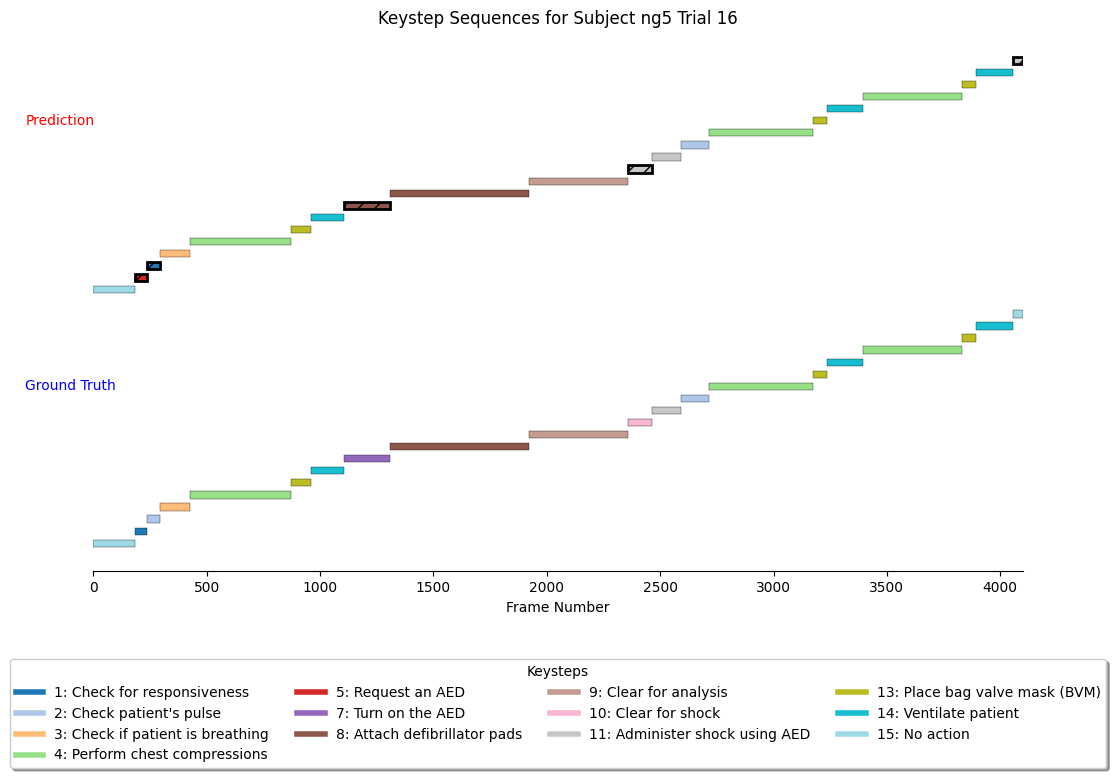

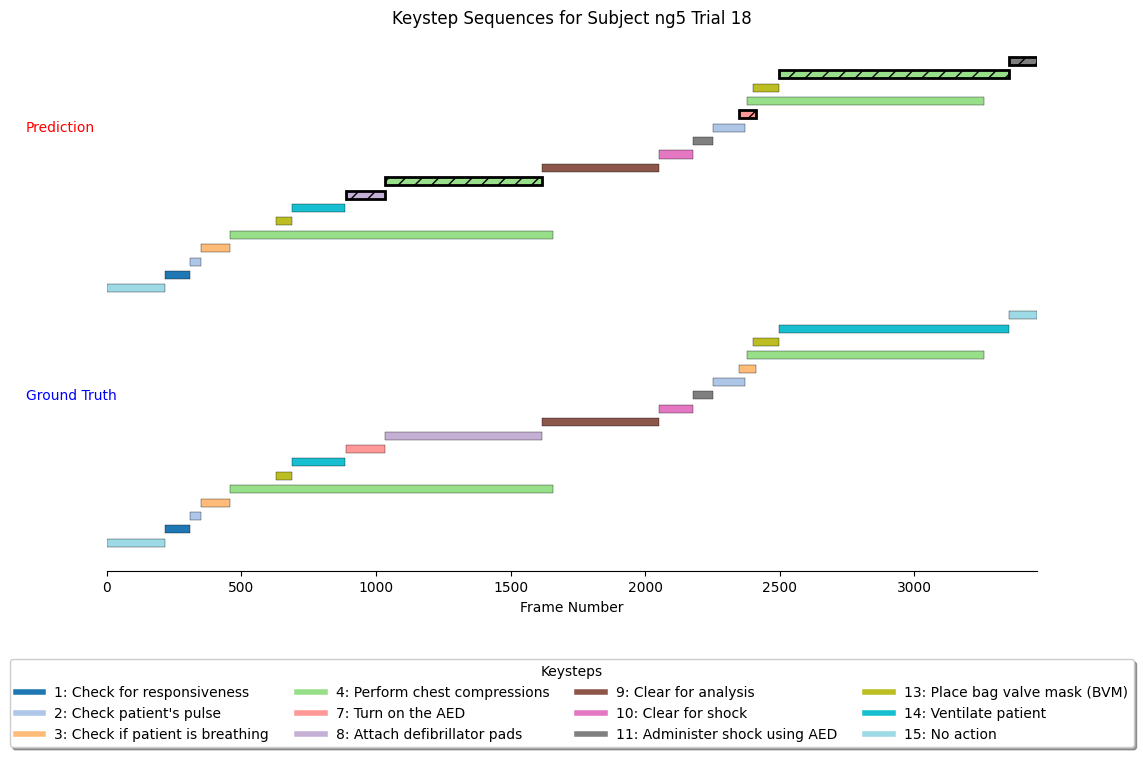

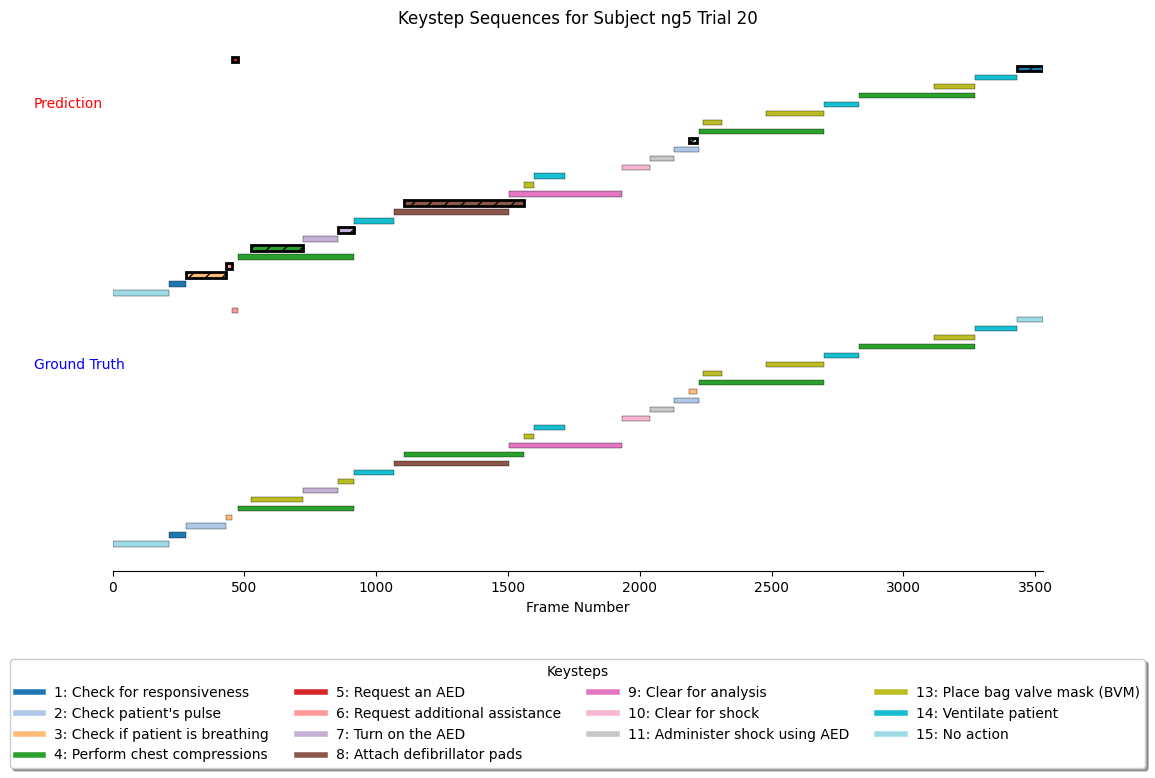

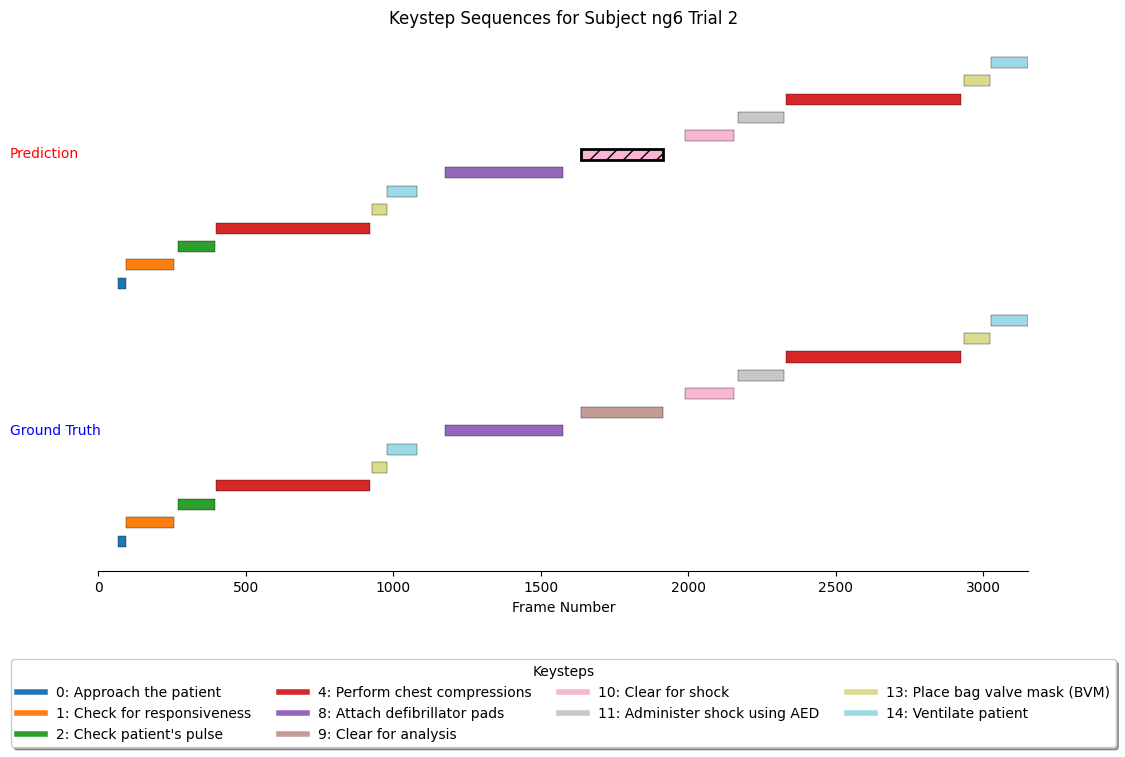

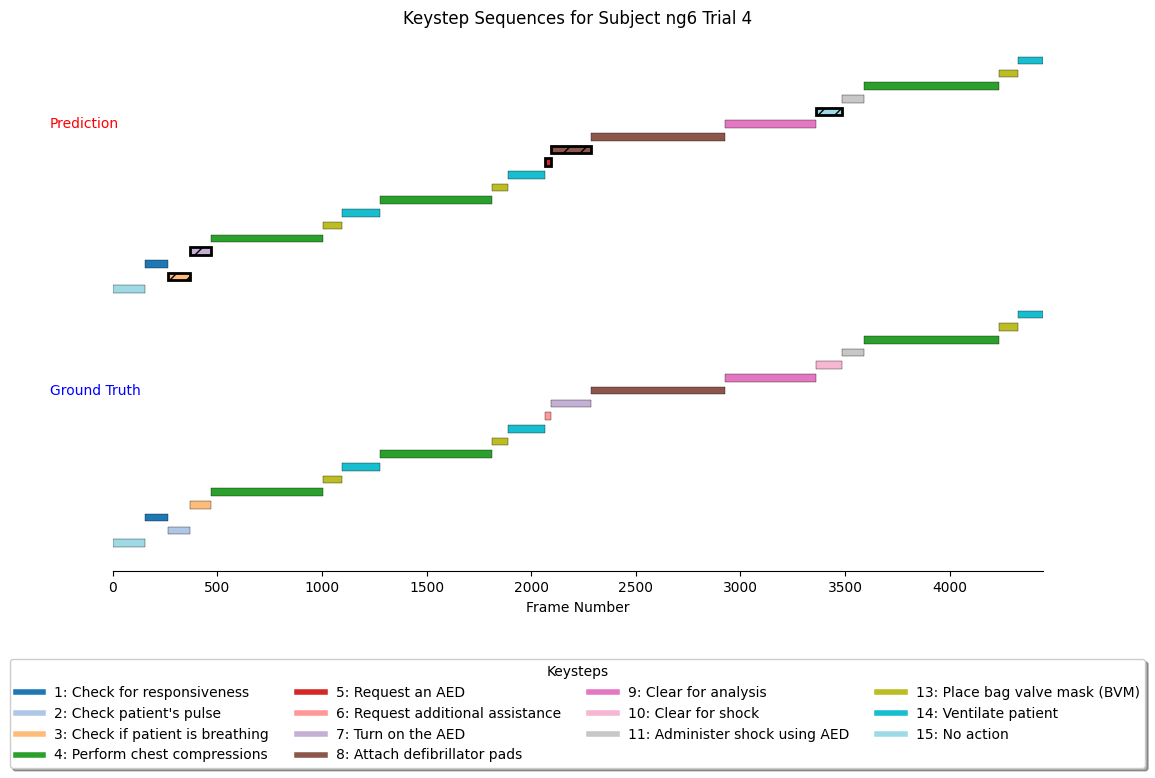

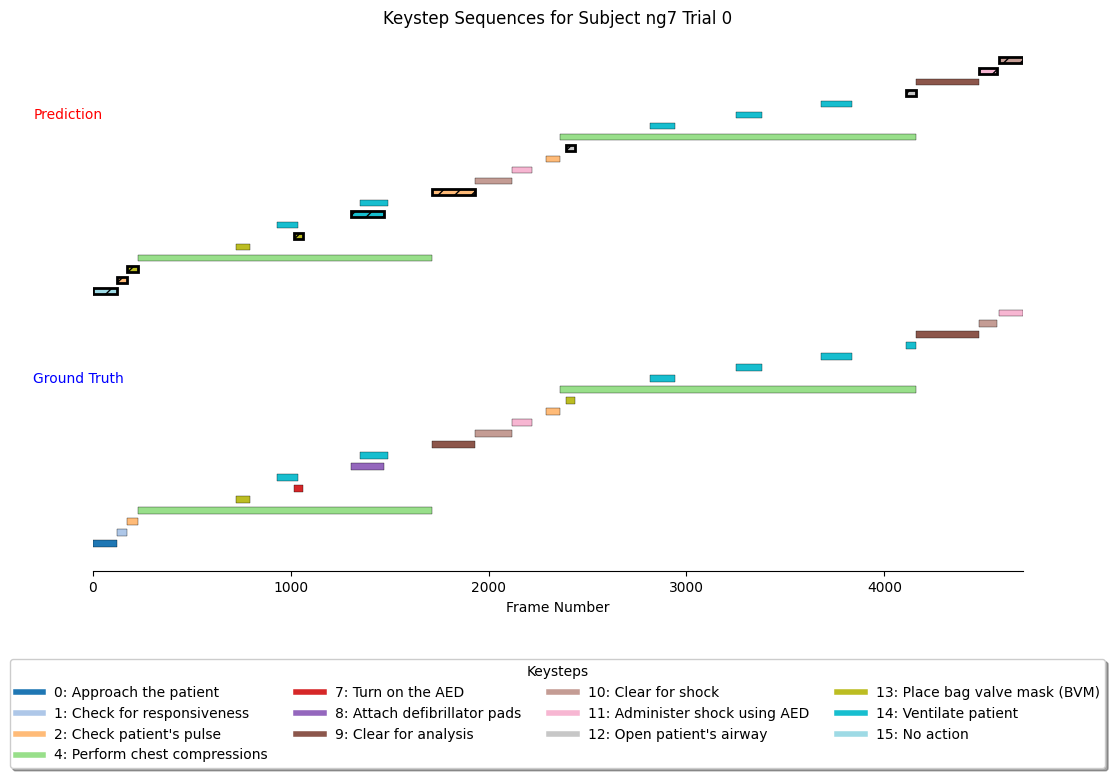

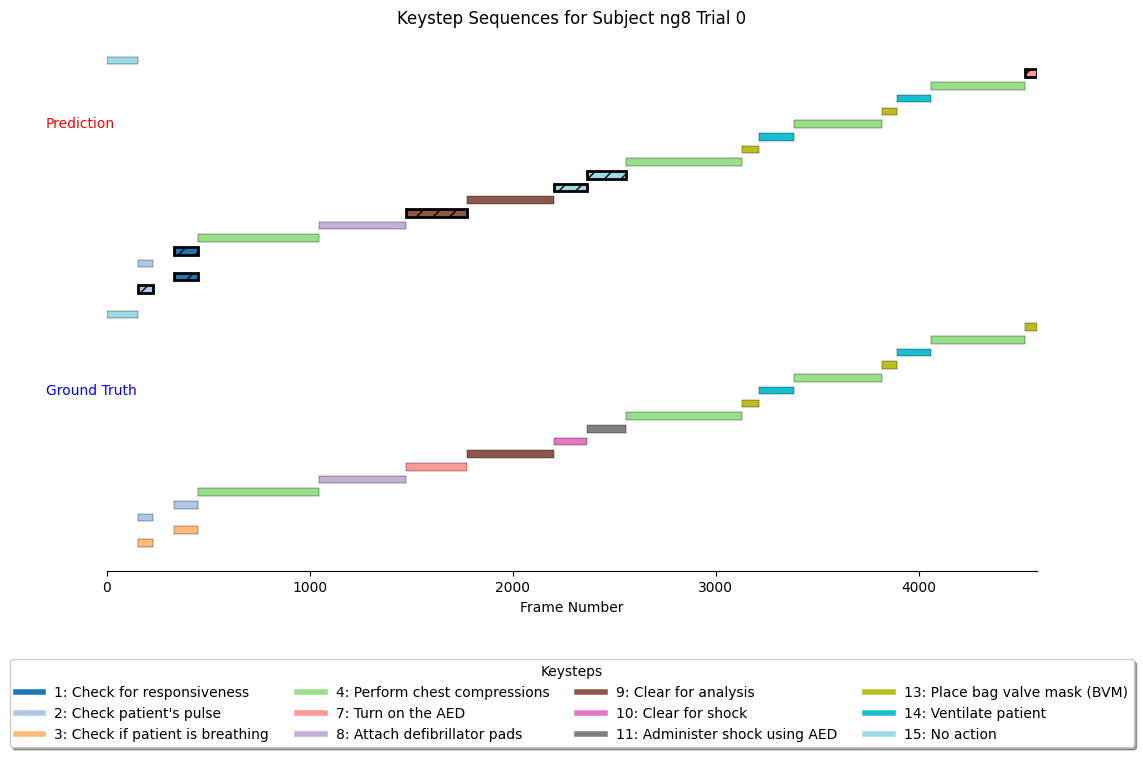

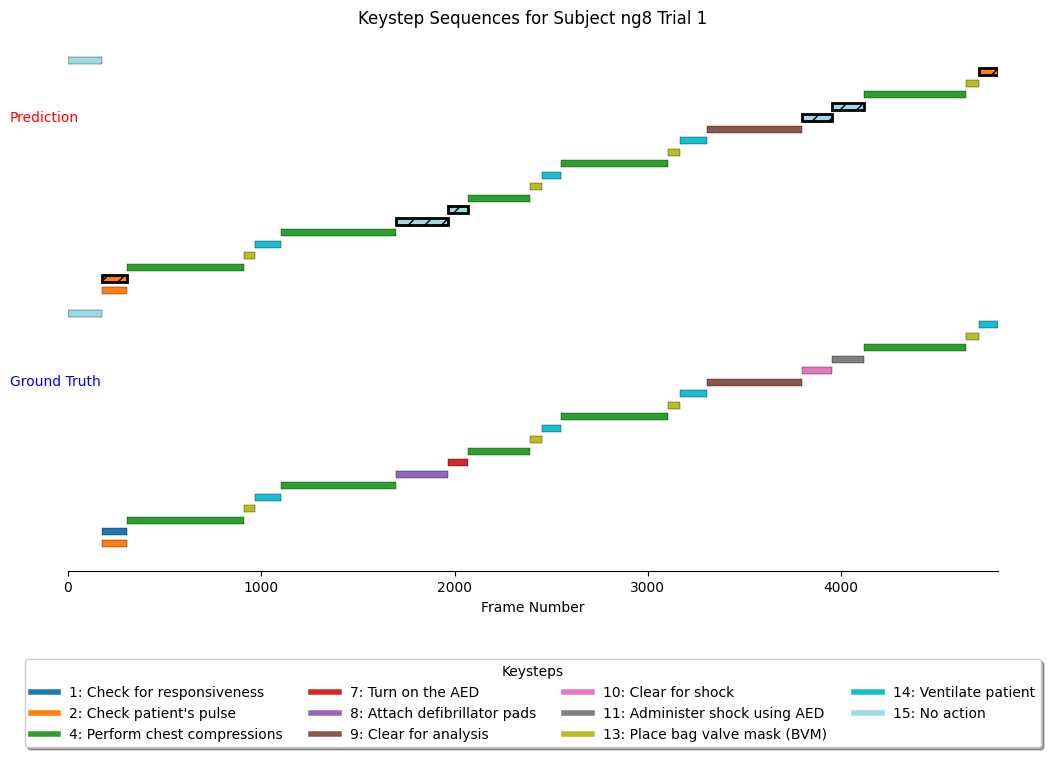

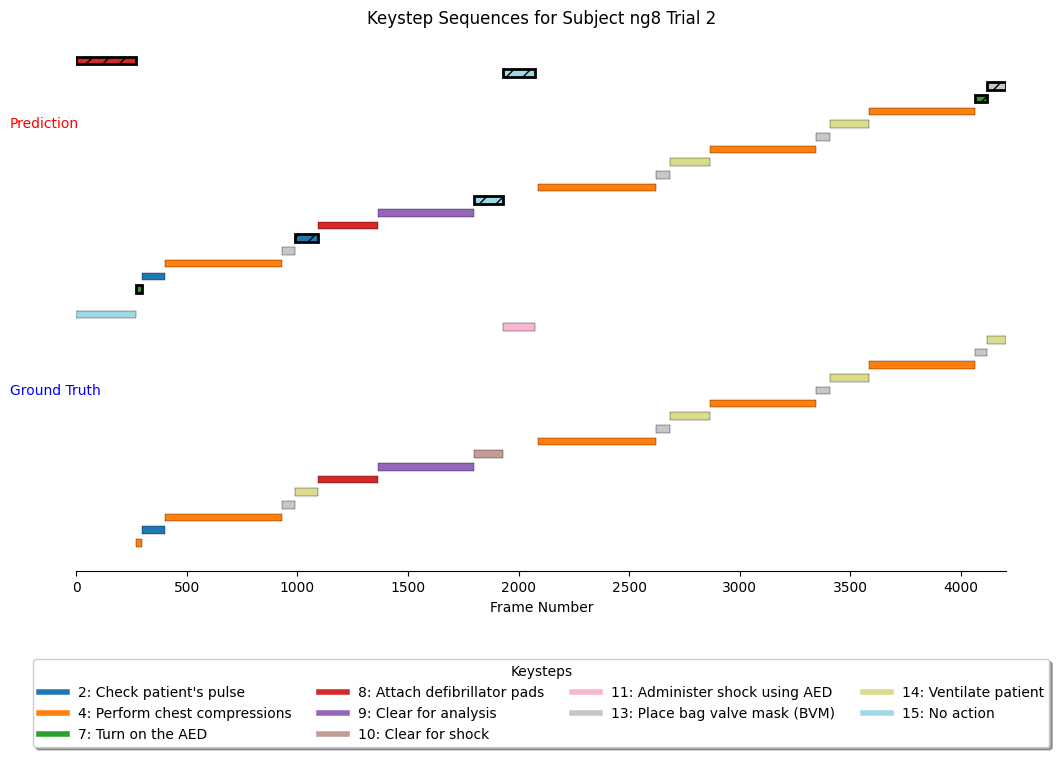

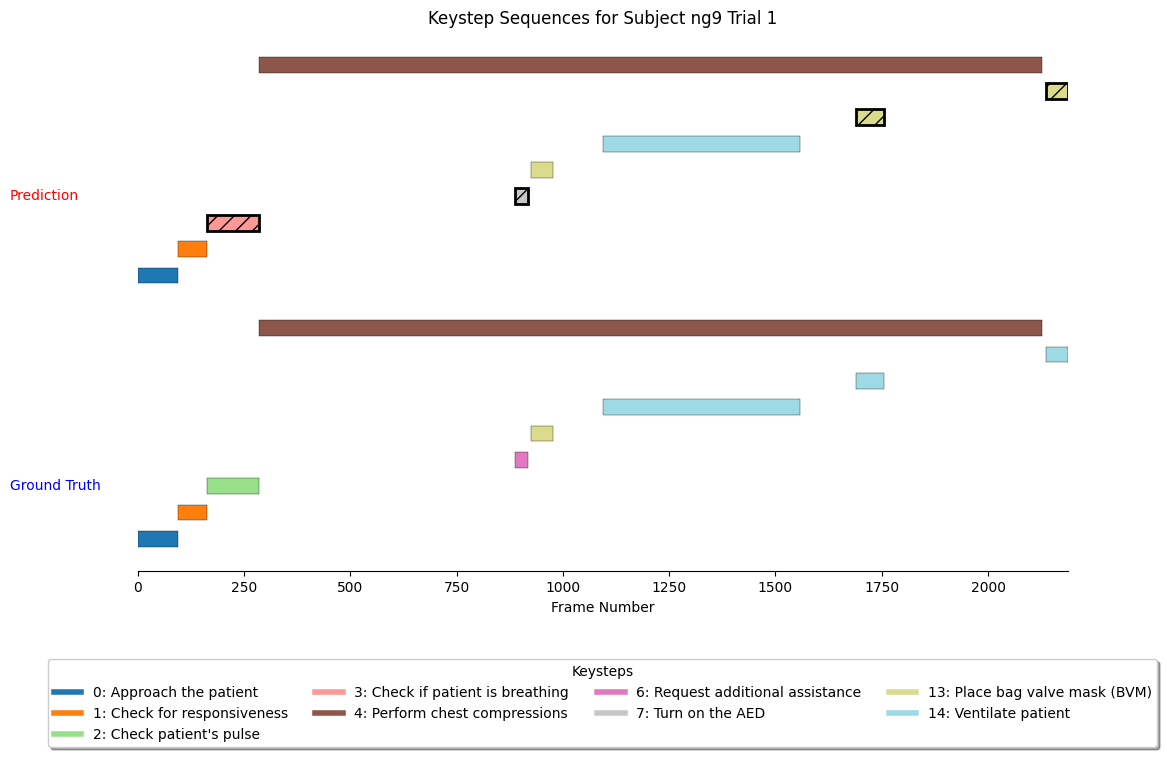

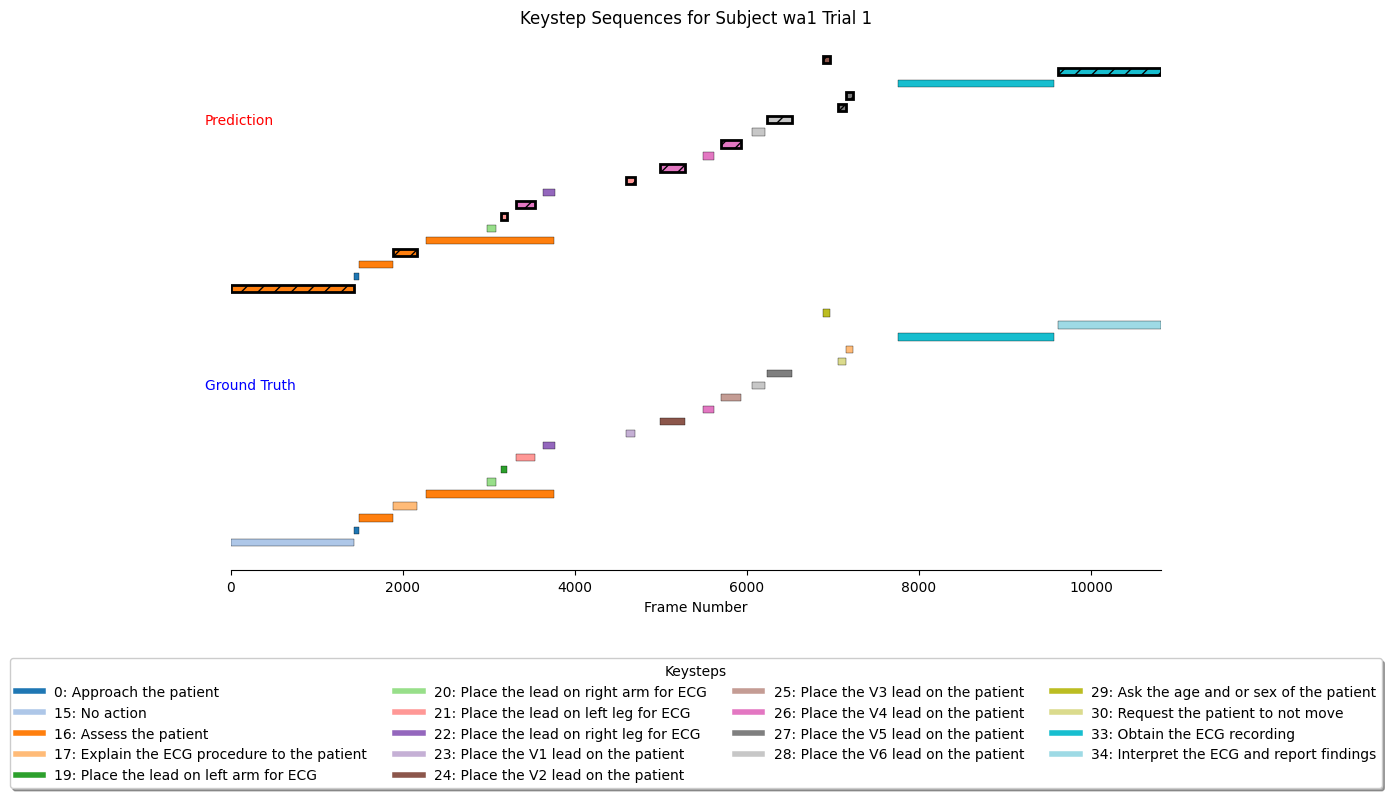

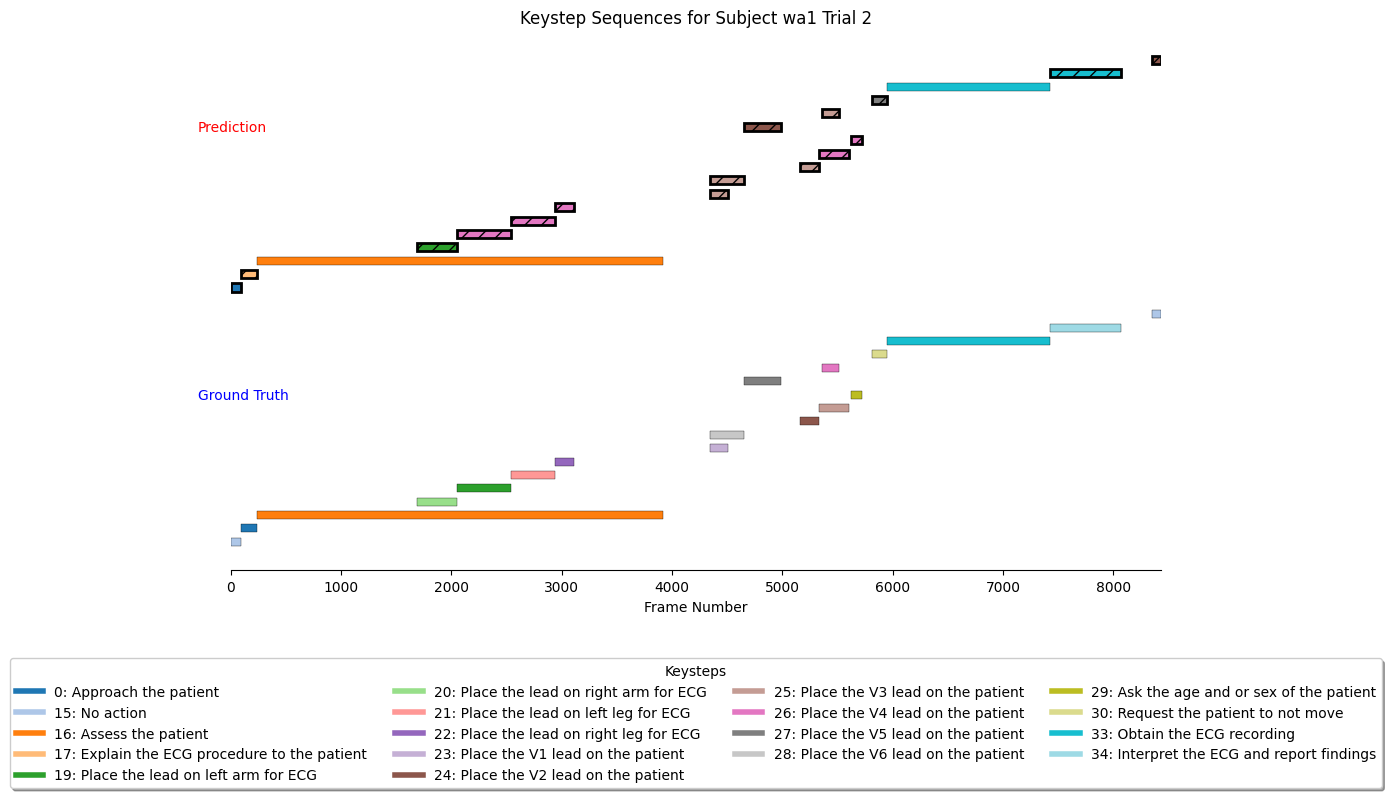

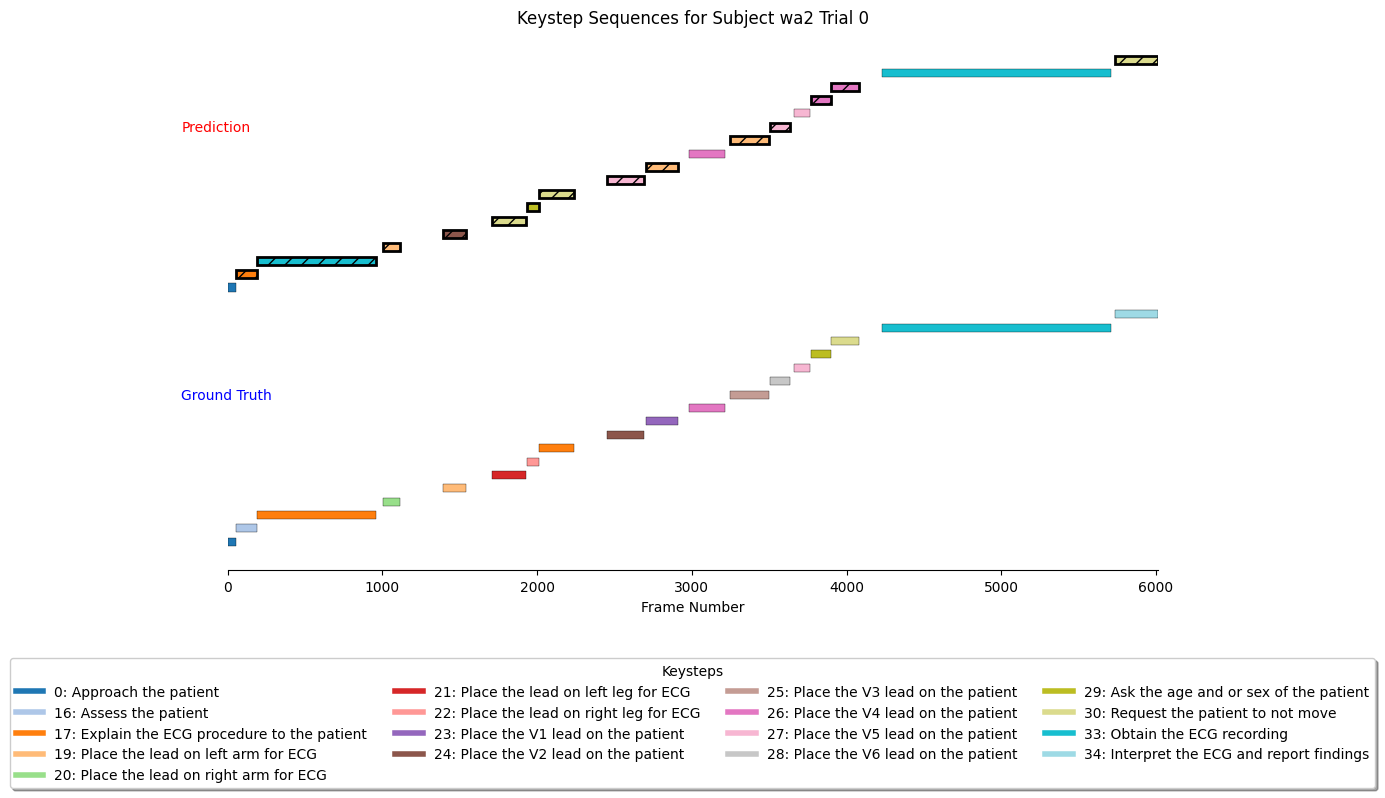

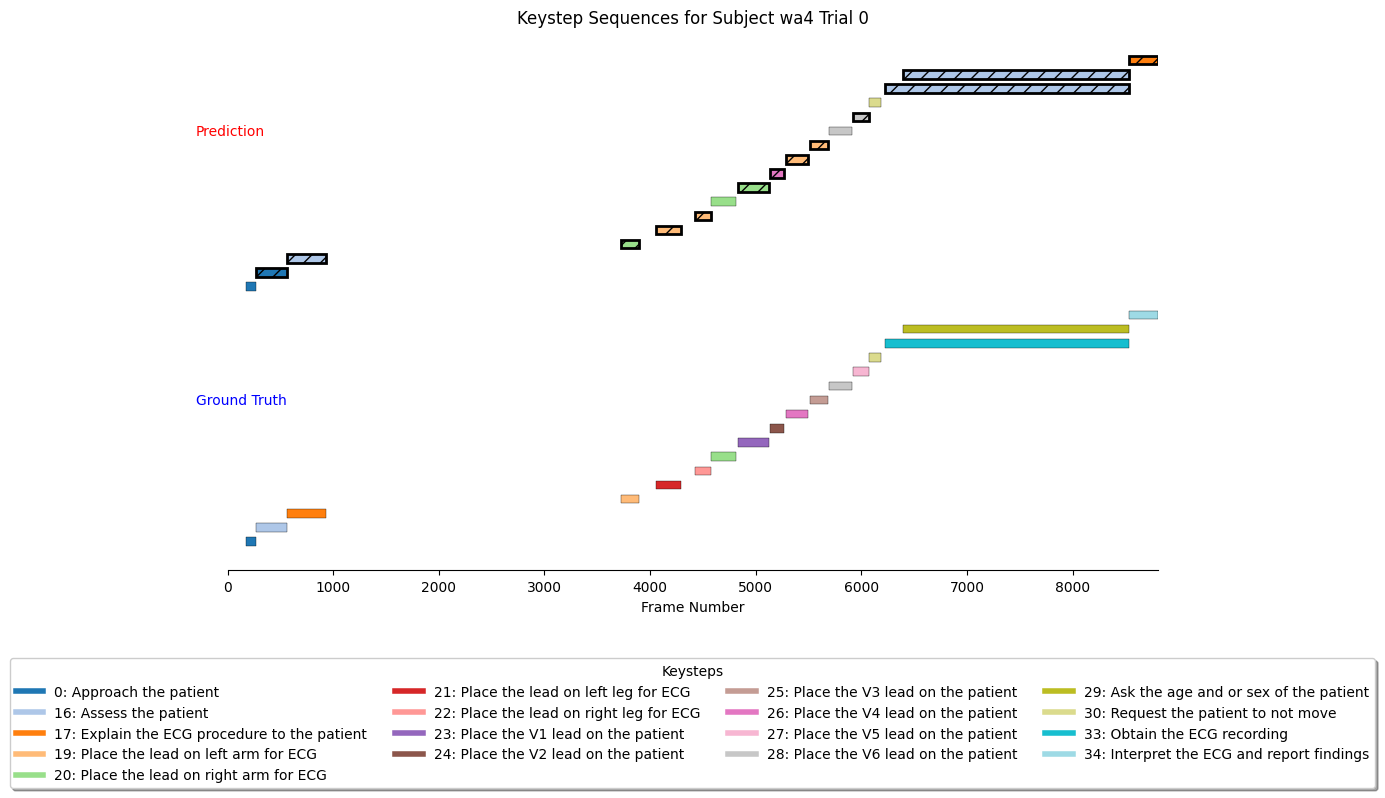

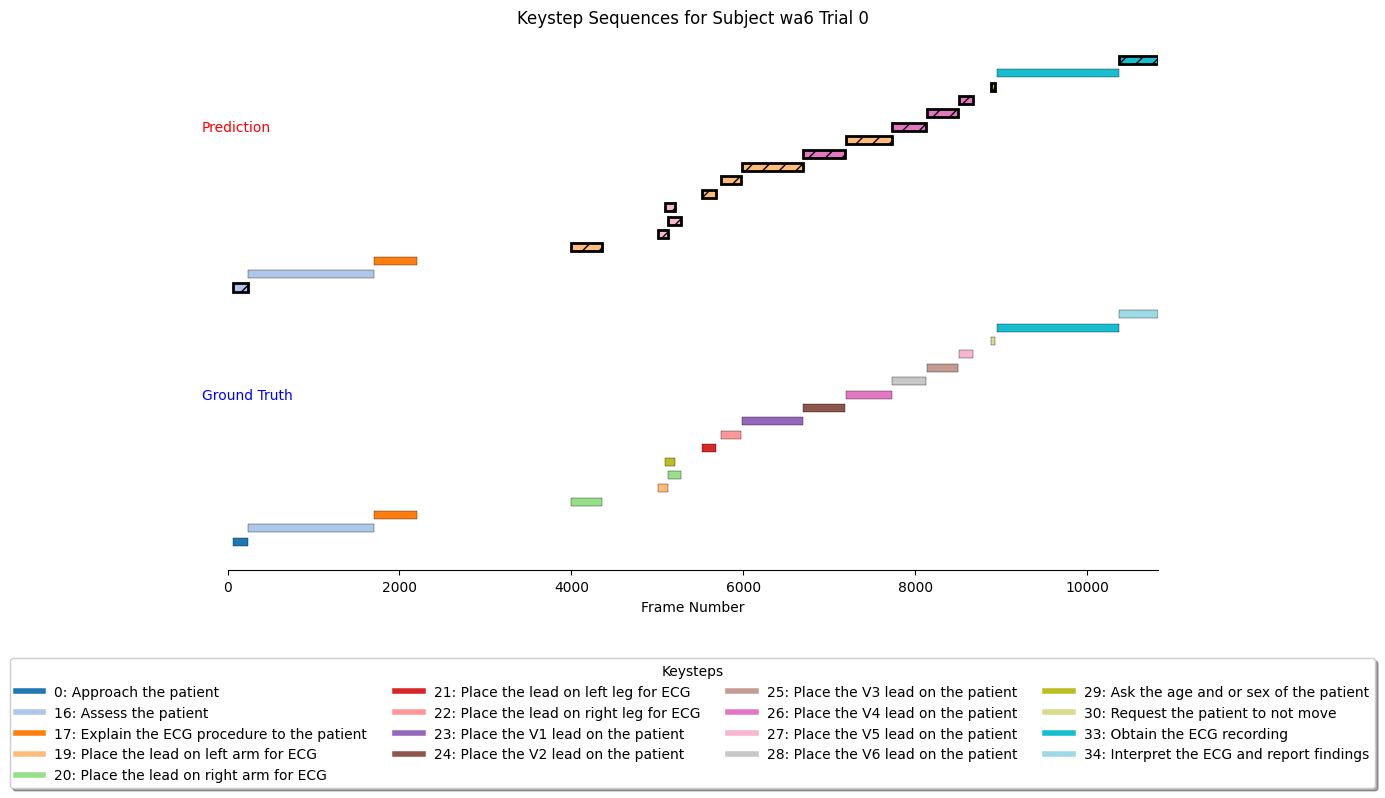

In [11]:


df = pd.read_csv(results_csv)

keysteps_dict = args.dataloader_params['keysteps']
print(keysteps_dict)

# Inverting the dictionary to map keystep_id to natural language description
keystep_id_to_desc = {i: v for i, v in enumerate(keysteps_dict.values())}

# Adding a new column to the dataframe that maps keystep_id to the corresponding natural language description
df['keystep_description'] = df['keystep_id'].map(keystep_id_to_desc)
df['pred_keystep_description'] = df['pred_keystep_id'].map(keystep_id_to_desc)

# Display the updated dataframe
df.head()

# get keysteps dict
keysteps_dict = args.dataloader_params['keysteps']
# Inverting the dictionary to map keystep_id to natural language description
keystep_id_to_desc = {i: v for i, v in enumerate(keysteps_dict.values())}

keysteps_dict = keystep_id_to_desc

# Example usage with one subject's trial data
for (subject, trial), group in df.groupby(['subject_id', 'trial_id']):
    ground_truth_data = group[['keystep_id', 'start_frame', 'end_frame']]
    predicted_data = group[['pred_keystep_id', 'start_frame', 'end_frame']]

    plots_dir = f'{results_dir}/plots/bar_plots'
    os.makedirs(plots_dir, exist_ok=True)
    # Plot using the keystep IDs with horizontal bar plot and color legend
    plot_keystep_bars(ground_truth_data, predicted_data, subject, trial, keysteps_dict, plots_dir)
    # break  # Only plot the first subject's trial for now


## Detail result plot


<Axes: >

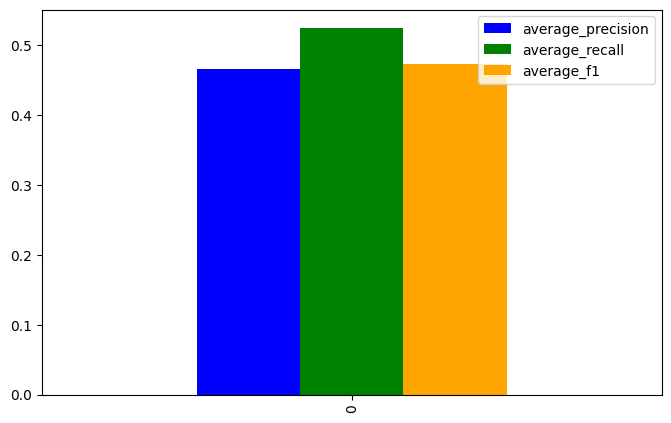

In [12]:
# plot average metrics (f1, precision, recall)
average_metrics_df = pd.read_csv(f'{results_dir}/average_metrics.csv')

# Plot the average metrics
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the average precision, recall, and f1 scores
average_metrics_df[['average_precision', 'average_recall', 'average_f1']].plot(kind='bar', ax=ax, color=['blue', 'green', 'orange'])


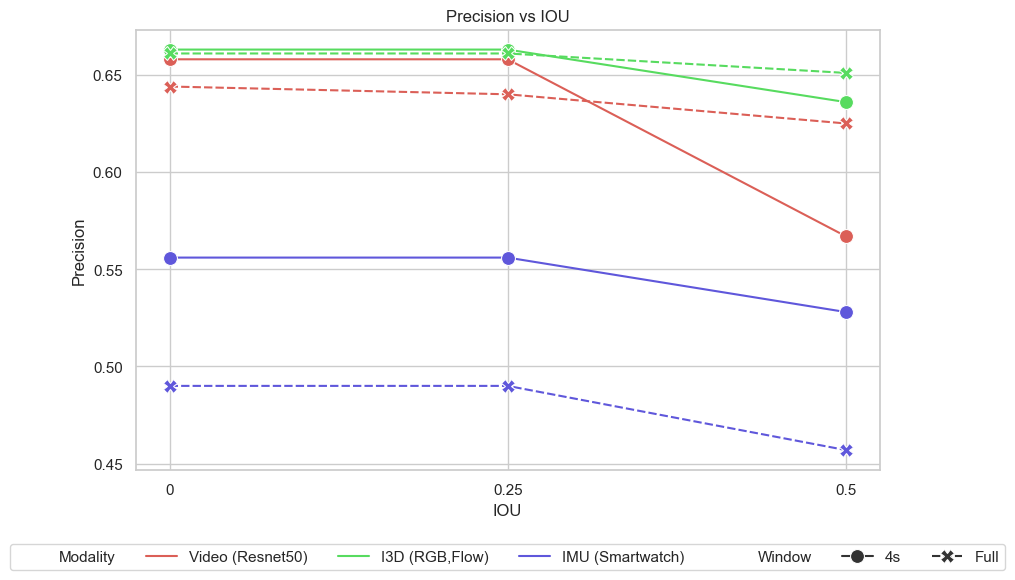

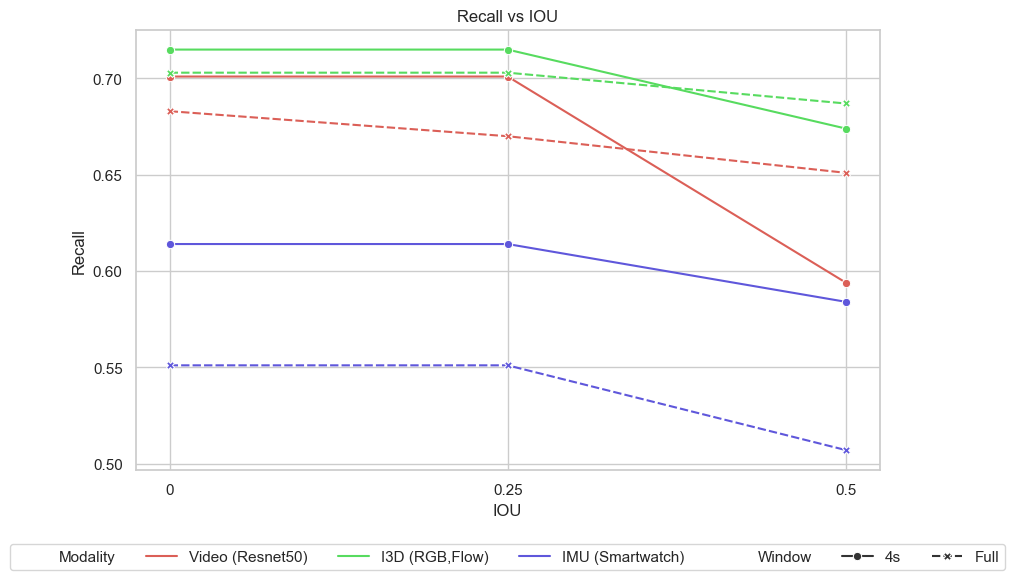

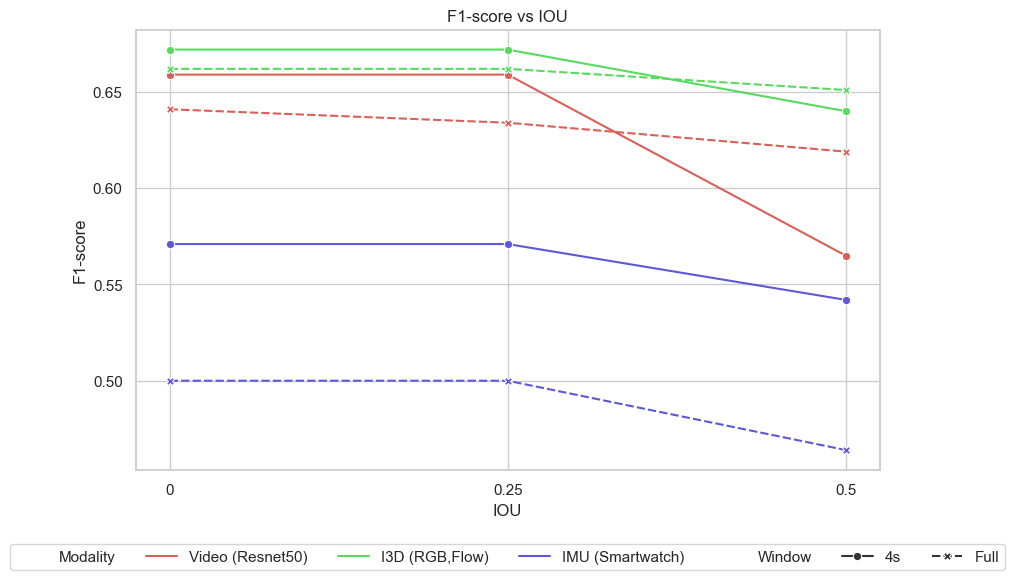

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Sample data from the table
data = {
    'Model': ['ICRA Model']*18,
    'Modality': ['Video (Resnet50)']*6 + ['I3D (RGB,Flow)']*6 + ['IMU (Smartwatch)']*6,
    'Window': ['4s']*3 + ['Full']*3 + ['4s']*3 + ['Full']*3 + ['4s']*3 + ['Full']*3,
    'IOU': ['0', '0.25', '0.5']*6,
    'Precision': [0.658, 0.658, 0.567, 0.644, 0.640, 0.625, 
                  0.663, 0.663, 0.636, 0.661, 0.661, 0.651, 
                  0.556, 0.556, 0.528, 0.490, 0.490, 0.457],
    'Recall': [0.701, 0.701, 0.594, 0.683, 0.670, 0.651, 
               0.715, 0.715, 0.674, 0.703, 0.703, 0.687, 
               0.614, 0.614, 0.584, 0.551, 0.551, 0.507],
    'F1-score': [0.659, 0.659, 0.565, 0.641, 0.634, 0.619, 
                 0.672, 0.672, 0.640, 0.662, 0.662, 0.651, 
                 0.571, 0.571, 0.542, 0.500, 0.500, 0.464],
    'Accuracy': [0.700, 0.700, 0.700, 0.680, 0.680, 0.680,
                 0.711, 0.711, 0.711, 0.701, 0.701, 0.701,
                 0.603, 0.603, 0.603, 0.562, 0.562, 0.562],
    'Edit Score': [0.862, 0.862, 0.862, 0.798, 0.798, 0.798,
                   0.865, 0.865, 0.865, 0.810, 0.810, 0.810,
                   0.839, 0.839, 0.839, 0.753, 0.753, 0.753],
    'Edit Distance': [4.909, 4.909, 4.909, 3.955, 3.955, 3.955,
                      4.909, 4.909, 4.909, 3.682, 3.682, 3.682,
                      5.591, 5.591, 5.591, 4.591, 4.591, 4.591]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Set plot style
sns.set_theme(style="whitegrid", palette=sns.color_palette("hls", 3))


# Plot 1: Precision for each modality and window size
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='IOU', y='Precision', hue='Modality', style='Window', markers=True, linewidth=1.5, markersize=10)
plt.title('Precision vs IOU')
plt.xlabel('IOU')
plt.ylabel('Precision')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7)
plt.savefig(f'{results_dir}/plots/precision_vs_iou.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

# Plot 2: Recall for each modality and window size
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='IOU', y='Recall', hue='Modality', style='Window', markers=True)
plt.title('Recall vs IOU')
plt.xlabel('IOU')
plt.ylabel('Recall')
plt.legend( loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7)
plt.savefig(f'{results_dir}/plots/recall_vs_iou.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

# Plot 3: F1-score for each modality and window size
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='IOU', y='F1-score', hue='Modality', style='Window', markers=True)
plt.title('F1-score vs IOU')
plt.xlabel('IOU')
plt.ylabel('F1-score')
plt.legend( loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7)
plt.savefig(f'{results_dir}/plots/f1_score_vs_iou.png', bbox_inches='tight')
plt.tight_layout()
plt.show()


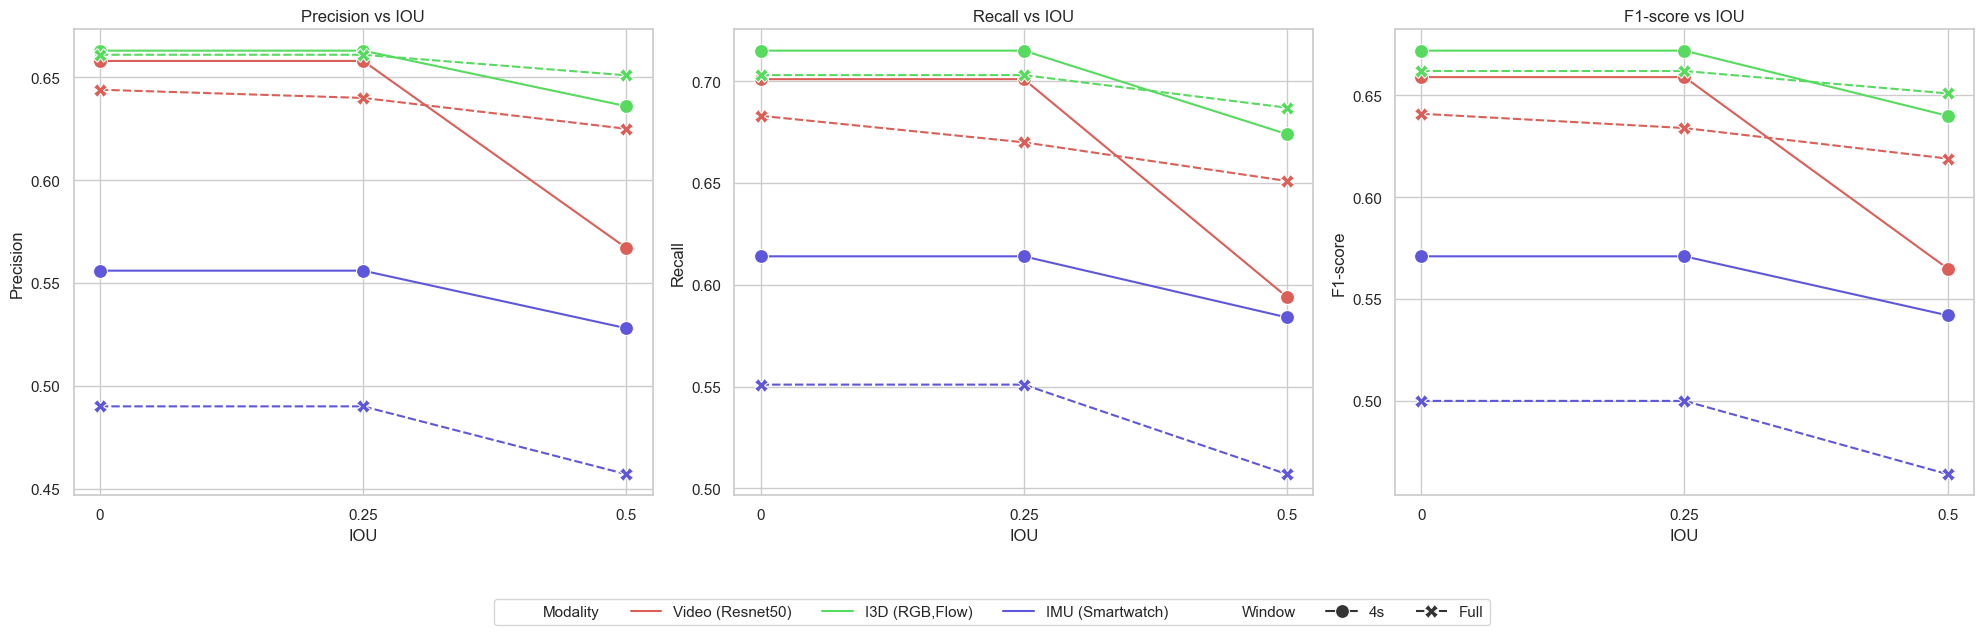

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data from the table
data = {
    'Model': ['ICRA Model']*18,
    'Modality': ['Video (Resnet50)']*6 + ['I3D (RGB,Flow)']*6 + ['IMU (Smartwatch)']*6,
    'Window': ['4s']*3 + ['Full']*3 + ['4s']*3 + ['Full']*3 + ['4s']*3 + ['Full']*3,
    'IOU': ['0', '0.25', '0.5']*6,
    'Precision': [0.658, 0.658, 0.567, 0.644, 0.640, 0.625, 
                  0.663, 0.663, 0.636, 0.661, 0.661, 0.651, 
                  0.556, 0.556, 0.528, 0.490, 0.490, 0.457],
    'Recall': [0.701, 0.701, 0.594, 0.683, 0.670, 0.651, 
               0.715, 0.715, 0.674, 0.703, 0.703, 0.687, 
               0.614, 0.614, 0.584, 0.551, 0.551, 0.507],
    'F1-score': [0.659, 0.659, 0.565, 0.641, 0.634, 0.619, 
                 0.672, 0.672, 0.640, 0.662, 0.662, 0.651, 
                 0.571, 0.571, 0.542, 0.500, 0.500, 0.464],
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Set plot style
sns.set_theme(style="whitegrid", palette=sns.color_palette("hls", 3))

# Create a figure with three subplots horizontally
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Precision vs IOU
sns.lineplot(data=df, x='IOU', y='Precision', hue='Modality', style='Window', markers=True, linewidth=1.5, markersize=10, ax=axes[0])
axes[0].set_title('Precision vs IOU')
axes[0].set_xlabel('IOU')
axes[0].set_ylabel('Precision')

# Plot 2: Recall vs IOU
sns.lineplot(data=df, x='IOU', y='Recall', hue='Modality', style='Window', markers=True, linewidth=1.5, markersize=10, ax=axes[1])
axes[1].set_title('Recall vs IOU')
axes[1].set_xlabel('IOU')
axes[1].set_ylabel('Recall')

# Plot 3: F1-score vs IOU
sns.lineplot(data=df, x='IOU', y='F1-score', hue='Modality', style='Window', markers=True, linewidth=1.5, markersize=10, ax=axes[2])
axes[2].set_title('F1-score vs IOU')
axes[2].set_xlabel('IOU')
axes[2].set_ylabel('F1-score')

# Remove legends from individual plots
axes[0].legend_.remove()
axes[1].legend_.remove()
axes[2].legend_.remove()

# Create a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=8)

plt.savefig(f'{results_dir}/plots/metrics_vs_iou.png', bbox_inches='tight')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend
plt.show()

